<a href="https://colab.research.google.com/github/MonicaCushy/CDSS/blob/main/%E7%89%A9%E7%90%86%E9%99%8D%E5%99%AA%E5%A4%B1%E8%B4%A5%2B%E8%B7%91LoRa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: 检查现有数据

# 挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# 加载我们之前处理好的数据
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell_promoters_with_seq.csv')

print(f"数据量: {len(df)}")
print(f"\n列名: {df.columns.tolist()}")
print(f"\n前几行:")
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
数据量: 4978

列名: ['TSS unique identifier', 'Strand', 'Coordinate (genome version NC_000962)', 'Mean coverage in converted libraries', 'Downstream same-strand gene', 'position relative to downstream same-strand gene', 'Overlapping same-strand gene', 'Position in overlapping same-strand gene', 'Position in overlapping same-strand gene relative to length', 'nt at +1', 'promoter_seq', 'expression']

前几行:
  TSS unique identifier Strand  Coordinate (genome version NC_000962)  \
0              1776702+      +                                1776702   
1               469591+      +                                 469591   
2              2485273+      +                                2485273   
3               645467+      +                                 645467   
4              1160434-      -                                1160434   

   Mean coverage in converted 

计算MFE中...

MFE统计:
count    4978.000000
mean      -13.827047
std         4.739311
min       -34.900002
25%       -16.900000
50%       -13.450000
75%       -10.600000
max        -0.700000
Name: mfe, dtype: float64


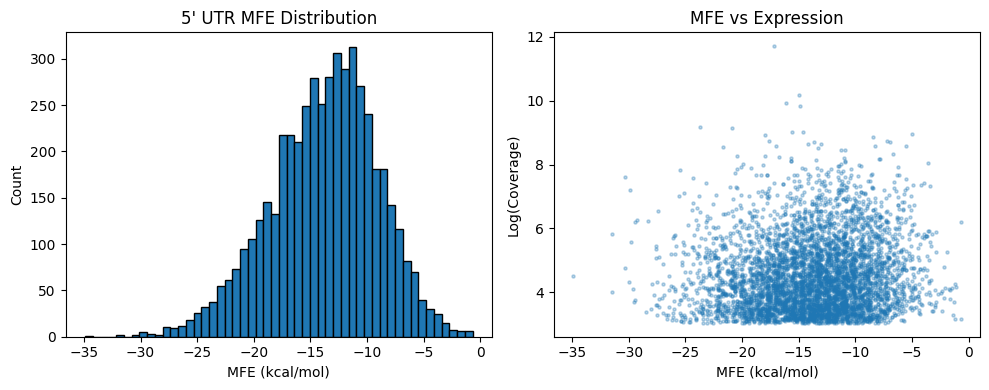


图片已保存


In [2]:
# Cell 2: 安装RNA折叠工具并计算MFE

!pip install ViennaRNA -q

import RNA
import numpy as np

def calculate_mfe(seq):
    """计算RNA序列的最小折叠自由能"""
    # DNA转RNA
    rna_seq = seq.replace('T', 'U')
    # 计算MFE
    structure, mfe = RNA.fold(rna_seq)
    return mfe

# 取promoter序列的后50bp（TSS下游，即5' UTR区域）
# 我们的promoter是TSS上游150bp + 下游50bp，所以后50bp是5' UTR

def get_5utr(promoter_seq):
    """获取5' UTR序列（后50bp）"""
    return promoter_seq[-50:] if len(promoter_seq) >= 50 else promoter_seq

# 计算所有样本的MFE
print("计算MFE中...")
df['utr_seq'] = df['promoter_seq'].apply(get_5utr)
df['mfe'] = df['utr_seq'].apply(calculate_mfe)

print(f"\nMFE统计:")
print(df['mfe'].describe())

# 看看分布
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df['mfe'], bins=50, edgecolor='black')
plt.xlabel('MFE (kcal/mol)')
plt.ylabel('Count')
plt.title('5\' UTR MFE Distribution')

plt.subplot(1, 2, 2)
plt.scatter(df['mfe'], np.log1p(df['expression']), alpha=0.3, s=5)
plt.xlabel('MFE (kcal/mol)')
plt.ylabel('Log(Coverage)')
plt.title('MFE vs Expression')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MycoPromoter/mfe_distribution.png', dpi=150)
plt.show()

print("\n图片已保存")

In [3]:
# Cell 3 修复版：重新下载并提取CDS

!pip install biopython -q

from Bio import Entrez, SeqIO
from collections import Counter
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Entrez.email = "your_email@example.com"

# 重新下载，用gbwithparts格式
print("下载基因组注释...")
handle = Entrez.efetch(db="nucleotide", id="NC_000962.3", rettype="gbwithparts", retmode="text")

# 保存到文件再读取（更稳定）
with open('/content/mtb_genome.gb', 'w') as f:
    f.write(handle.read())
handle.close()

print("解析GenBank文件...")
record = SeqIO.read('/content/mtb_genome.gb', 'genbank')

print(f"基因组长度: {len(record.seq)}")
print(f"Features数量: {len(record.features)}")

# 看看有哪些feature类型
feature_types = Counter(f.type for f in record.features)
print(f"Feature类型: {feature_types}")

# 提取CDS
cds_dict = {}
for feature in record.features:
    if feature.type == "CDS":
        # 尝试获取locus_tag
        locus = None
        if 'locus_tag' in feature.qualifiers:
            locus = feature.qualifiers['locus_tag'][0]
        elif 'gene' in feature.qualifiers:
            locus = feature.qualifiers['gene'][0]

        if locus:
            try:
                cds_seq = str(feature.extract(record.seq))
                cds_dict[locus] = cds_seq
            except:
                pass

print(f"\n提取了 {len(cds_dict)} 个CDS")
if len(cds_dict) > 0:
    print(f"示例基因ID: {list(cds_dict.keys())[:10]}")
    print(f"示例序列长度: {[len(v) for v in list(cds_dict.values())[:5]]}")

下载基因组注释...
解析GenBank文件...
基因组长度: 4411532
Features数量: 8336
Feature类型: Counter({'gene': 4008, 'CDS': 3906, 'repeat_region': 262, 'mobile_element': 56, 'tRNA': 45, 'misc_feature': 33, 'ncRNA': 20, 'rRNA': 3, 'misc_RNA': 2, 'source': 1})

提取了 3906 个CDS
示例基因ID: ['Rv0001', 'Rv0002', 'Rv0003', 'Rv0004', 'Rv0005', 'Rv0006', 'Rv0007', 'Rv0008c', 'Rv0009', 'Rv0010c']
示例序列长度: [1524, 1209, 1158, 564, 2028]


计算参考密码子频率...
总密码子数: 1319440
计算了 61 个密码子的RSCU

Shell数据里的基因ID示例:
['Rv1570', 'Rv0391', 'Rv2219', 'Rv0555', 'Rv1036c', 'Rv1951c', 'Rv1257c', 'Rv1693', 'Rv0445c', 'Rv0809']

CDS字典里的基因ID示例:
['Rv0001', 'Rv0002', 'Rv0003', 'Rv0004', 'Rv0005', 'Rv0006', 'Rv0007', 'Rv0008c', 'Rv0009', 'Rv0010c']

计算每个TSS对应基因的CAI...
成功匹配并计算CAI: 4845 / 4978

CAI统计:
count    4845.000000
mean        0.661574
std         0.061067
min         0.442652
25%         0.626799
50%         0.664738
75%         0.700786
max         0.857030
Name: cai, dtype: float64


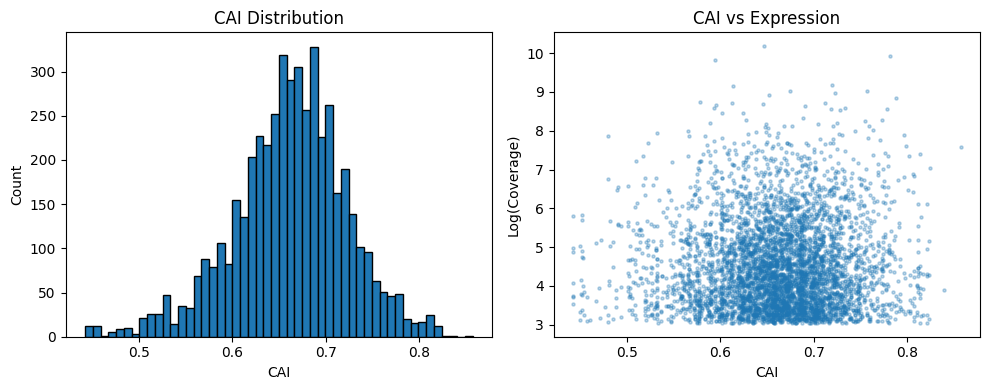


CAI与Log(Coverage)的相关性:
Spearman: 0.0095 (p=5.07e-01)
Pearson: 0.0251 (p=8.08e-02)


In [4]:
# Cell 4: 计算CAI并分析

# 计算密码子使用频率
def get_codon_usage(cds_sequences):
    codon_counts = Counter()
    for seq in cds_sequences:
        seq = seq[:len(seq) - len(seq) % 3]
        for i in range(0, len(seq), 3):
            codon = seq[i:i+3]
            if len(codon) == 3 and all(c in 'ATCG' for c in codon):
                codon_counts[codon] += 1
    return codon_counts

print("计算参考密码子频率...")
ref_codon_usage = get_codon_usage(cds_dict.values())
print(f"总密码子数: {sum(ref_codon_usage.values())}")

# 密码子到氨基酸
codon_to_aa = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

aa_to_codons = {}
for codon, aa in codon_to_aa.items():
    if aa not in aa_to_codons:
        aa_to_codons[aa] = []
    aa_to_codons[aa].append(codon)

# 计算RSCU
rscu = {}
for aa, codons in aa_to_codons.items():
    if aa == '*':
        continue
    codon_freqs = {c: ref_codon_usage.get(c, 0) for c in codons}
    total = sum(codon_freqs.values())
    if total > 0:
        n = len(codons)
        for c in codons:
            expected = total / n
            rscu[c] = codon_freqs[c] / expected if expected > 0 else 0

print(f"计算了 {len(rscu)} 个密码子的RSCU")

# 计算CAI函数
def calculate_cai(cds_seq):
    if len(cds_seq) < 6:
        return None
    cds_seq = cds_seq[:len(cds_seq) - len(cds_seq) % 3]
    log_sum = 0
    count = 0
    for i in range(0, len(cds_seq) - 3, 3):
        codon = cds_seq[i:i+3]
        if codon not in codon_to_aa or codon_to_aa[codon] == '*':
            continue
        if codon in rscu and rscu[codon] > 0:
            aa = codon_to_aa[codon]
            synonymous = [c for c in aa_to_codons[aa] if codon_to_aa.get(c) != '*']
            max_rscu = max(rscu.get(c, 0) for c in synonymous)
            if max_rscu > 0:
                w = rscu[codon] / max_rscu
                if w > 0:
                    log_sum += math.log(w)
                    count += 1
    if count == 0:
        return None
    return math.exp(log_sum / count)

# 检查Shell数据里的基因ID格式
print("\nShell数据里的基因ID示例:")
print(df['Downstream same-strand gene'].dropna().head(10).tolist())
print("\nCDS字典里的基因ID示例:")
print(list(cds_dict.keys())[:10])

# 为每个TSS计算CAI
print("\n计算每个TSS对应基因的CAI...")
cai_values = []
matched = 0
for idx, row in df.iterrows():
    gene_id = row['Downstream same-strand gene']

    # 如果没匹配上，试试Overlapping gene
    if pd.isna(gene_id) or gene_id not in cds_dict:
        gene_id = row['Overlapping same-strand gene']

    if pd.isna(gene_id) or gene_id == 'none' or gene_id not in cds_dict:
        cai_values.append(None)
    else:
        cai = calculate_cai(cds_dict[gene_id])
        cai_values.append(cai)
        if cai is not None:
            matched += 1

df['cai'] = cai_values

print(f"成功匹配并计算CAI: {matched} / {len(df)}")

# 统计
valid_cai = df['cai'].dropna()
print(f"\nCAI统计:")
print(valid_cai.describe())

# 可视化
if len(valid_cai) > 0:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.hist(valid_cai, bins=50, edgecolor='black')
    plt.xlabel('CAI')
    plt.ylabel('Count')
    plt.title('CAI Distribution')

    plt.subplot(1, 2, 2)
    df_valid = df.dropna(subset=['cai'])
    plt.scatter(df_valid['cai'], np.log1p(df_valid['expression']), alpha=0.3, s=5)
    plt.xlabel('CAI')
    plt.ylabel('Log(Coverage)')
    plt.title('CAI vs Expression')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/MycoPromoter/cai_distribution.png', dpi=150)
    plt.show()

    # 计算相关性
    from scipy.stats import spearmanr, pearsonr
    corr_spearman, p_spearman = spearmanr(df_valid['cai'], np.log1p(df_valid['expression']))
    corr_pearson, p_pearson = pearsonr(df_valid['cai'], np.log1p(df_valid['expression']))
    print(f"\nCAI与Log(Coverage)的相关性:")
    print(f"Spearman: {corr_spearman:.4f} (p={p_spearman:.2e})")
    print(f"Pearson: {corr_pearson:.4f} (p={p_pearson:.2e})")
else:
    print("没有成功计算CAI，检查基因ID匹配问题")

MFE与Log(Coverage)的相关性:
Spearman: 0.0916 (p=9.66e-11)

计算更多序列特征...

各特征与Log(Coverage)的Spearman相关性:
  mfe            : +0.0916 (p=9.66e-11) ***
  cai            : +0.0095 (p=5.07e-01) 
  gc_total       : -0.0685 (p=1.30e-06) ***
  gc_5utr        : -0.1132 (p=1.16e-15) ***
  gc_promoter    : -0.0139 (p=3.26e-01) 


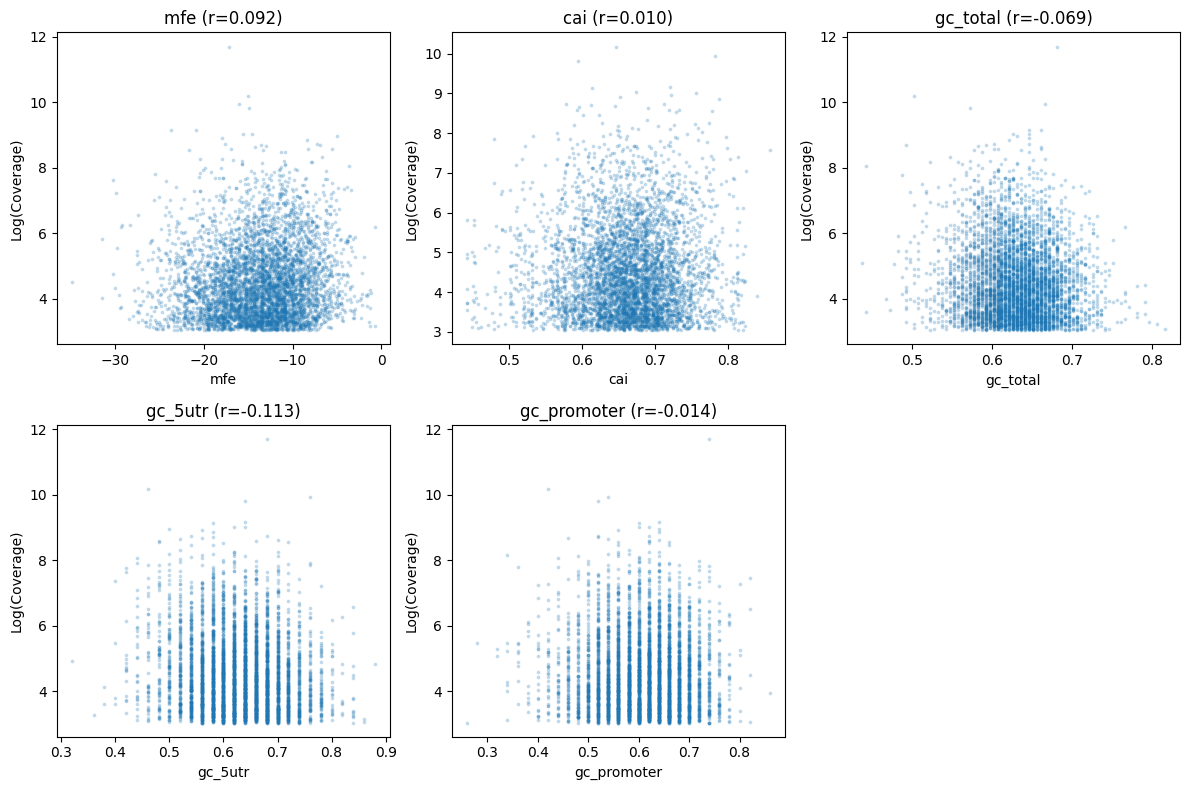

In [5]:
# Cell 5: 检查MFE的相关性，并尝试组合去噪

from scipy.stats import spearmanr, pearsonr

# MFE相关性
df_valid = df.dropna(subset=['mfe'])
corr_mfe, p_mfe = spearmanr(df_valid['mfe'], np.log1p(df_valid['expression']))
print(f"MFE与Log(Coverage)的相关性:")
print(f"Spearman: {corr_mfe:.4f} (p={p_mfe:.2e})")

# 再加一些序列特征
print("\n计算更多序列特征...")

def calc_gc_content(seq):
    return (seq.count('G') + seq.count('C')) / len(seq)

def calc_gc_5utr(seq):
    """5' UTR区域的GC含量"""
    utr = seq[-50:] if len(seq) >= 50 else seq
    return (utr.count('G') + utr.count('C')) / len(utr)

def calc_gc_promoter(seq):
    """promoter核心区域的GC含量（-50到TSS）"""
    core = seq[100:150] if len(seq) >= 150 else seq
    return (core.count('G') + core.count('C')) / len(core)

df['gc_total'] = df['promoter_seq'].apply(calc_gc_content)
df['gc_5utr'] = df['promoter_seq'].apply(calc_gc_5utr)
df['gc_promoter'] = df['promoter_seq'].apply(calc_gc_promoter)

# 检查所有特征的相关性
print("\n各特征与Log(Coverage)的Spearman相关性:")
features = ['mfe', 'cai', 'gc_total', 'gc_5utr', 'gc_promoter']
for feat in features:
    df_temp = df.dropna(subset=[feat])
    corr, p = spearmanr(df_temp[feat], np.log1p(df_temp['expression']))
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    print(f"  {feat:15s}: {corr:+.4f} (p={p:.2e}) {sig}")

# 可视化所有特征
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, feat in enumerate(features):
    df_temp = df.dropna(subset=[feat])
    axes[i].scatter(df_temp[feat], np.log1p(df_temp['expression']), alpha=0.2, s=3)
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('Log(Coverage)')
    corr, _ = spearmanr(df_temp[feat], np.log1p(df_temp['expression']))
    axes[i].set_title(f'{feat} (r={corr:.3f})')

# 隐藏多余的subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MycoPromoter/all_features_correlation.png', dpi=150)
plt.show()

In [6]:
# Cell 6: 尝试用所有特征做线性回归去噪，看看能提升多少

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# 准备数据
df_model = df.dropna(subset=['mfe', 'cai', 'gc_5utr']).copy()
print(f"有完整特征的样本: {len(df_model)}")

# 特征矩阵
X = df_model[['mfe', 'cai', 'gc_total', 'gc_5utr', 'gc_promoter']].values
y = np.log1p(df_model['expression'].values)

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 线性回归
reg = LinearRegression()
reg.fit(X_scaled, y)

# 预测和残差
y_pred = reg.predict(X_scaled)
residuals = y - y_pred

print(f"\n线性回归 R² = {reg.score(X_scaled, y):.4f}")
print(f"这意味着物理特征只解释了 {reg.score(X_scaled, y)*100:.1f}% 的variance")

# 特征重要性
print("\n特征系数 (标准化后):")
for feat, coef in zip(['mfe', 'cai', 'gc_total', 'gc_5utr', 'gc_promoter'], reg.coef_):
    print(f"  {feat:15s}: {coef:+.4f}")

# 残差就是"去噪后的promoter strength"
df_model['denoised_label'] = residuals

# 保存
df_model.to_csv('/content/drive/MyDrive/MycoPromoter/shell_denoised.csv', index=False)
print(f"\n保存了去噪后的数据: {len(df_model)} 样本")

# 对比原始label和去噪label
print("\n原始 vs 去噪 label的分布:")
print(f"原始 Log(Coverage): mean={y.mean():.2f}, std={y.std():.2f}")
print(f"去噪后残差: mean={residuals.mean():.2f}, std={residuals.std():.2f}")

有完整特征的样本: 4845

线性回归 R² = 0.0195
这意味着物理特征只解释了 1.9% 的variance

特征系数 (标准化后):
  mfe            : -0.0110
  cai            : +0.0394
  gc_total       : -0.0471
  gc_5utr        : -0.1363
  gc_promoter    : +0.0188

保存了去噪后的数据: 4845 样本

原始 vs 去噪 label的分布:
原始 Log(Coverage): mean=4.49, std=1.13
去噪后残差: mean=0.00, std=1.12


In [7]:
# Cell 7: 转为分类问题

# 取极端值做二分类
top_25 = df_model['expression'].quantile(0.75)
bottom_25 = df_model['expression'].quantile(0.25)

df_extreme = df_model[(df_model['expression'] >= top_25) | (df_model['expression'] <= bottom_25)].copy()
df_extreme['label'] = (df_extreme['expression'] >= top_25).astype(int)

print(f"极端样本数: {len(df_extreme)}")
print(f"高表达: {df_extreme['label'].sum()}")
print(f"低表达: {len(df_extreme) - df_extreme['label'].sum()}")

# 保存分类数据
df_extreme.to_csv('/content/drive/MyDrive/MycoPromoter/shell_classification.csv', index=False)
print("保存了分类数据集")

极端样本数: 2462
高表达: 1212
低表达: 1250
保存了分类数据集


In [8]:
# Cell 8: 构造Pairwise Ranking数据集

import itertools
import random

df_clean = df.dropna(subset=['promoter_seq', 'expression']).copy()
df_clean['log_expr'] = np.log1p(df_clean['expression'])

# 关键参数：只保留差异显著的pair
DELTA = 1.0  # log差异阈值，相当于~2.7倍差异

# 为了效率，随机采样而不是全组合
sequences = df_clean['promoter_seq'].tolist()
log_exprs = df_clean['log_expr'].tolist()
indices = list(range(len(df_clean)))

pairs = []
n_samples = 100000  # 采样10万对

random.seed(42)
for _ in range(n_samples * 3):  # 多采一些，因为会过滤掉很多
    i, j = random.sample(indices, 2)
    diff = log_exprs[i] - log_exprs[j]

    if abs(diff) > DELTA:
        # label: 1 if i > j, 0 if i < j
        if diff > 0:
            pairs.append((sequences[i], sequences[j], 1))
        else:
            pairs.append((sequences[j], sequences[i], 1))  # 统一格式：第一个总是更强的

    if len(pairs) >= n_samples:
        break

print(f"生成了 {len(pairs)} 个有效pair")

# 保存
import pickle
with open('/content/drive/MyDrive/MycoPromoter/ranking_pairs.pkl', 'wb') as f:
    pickle.dump(pairs, f)

print("保存完成")

# 统计差异分布
diffs = [abs(log_exprs[i] - log_exprs[j]) for i, j in random.sample(list(itertools.combinations(indices, 2)), 10000)]
print(f"\n随机pair的log差异分布:")
print(f"  Mean: {np.mean(diffs):.2f}")
print(f"  Median: {np.median(diffs):.2f}")
print(f"  >1.0的比例: {sum(d > 1.0 for d in diffs) / len(diffs) * 100:.1f}%")

生成了 100000 个有效pair
保存完成

随机pair的log差异分布:
  Mean: 1.24
  Median: 0.97
  >1.0的比例: 49.0%


In [1]:
# Cell 9 彻底修复版: 强制禁用Flash Attention

import os
os.environ["DNABERT_DISABLE_FLASH"] = "1"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig, BertModel, BertConfig
import pickle
from sklearn.model_selection import train_test_split

# 加载数据
with open('/content/drive/MyDrive/MycoPromoter/ranking_pairs.pkl', 'rb') as f:
    pairs = pickle.load(f)

print(f"加载了 {len(pairs)} 个pair")

train_pairs, val_pairs = train_test_split(pairs, test_size=0.1, random_state=42)
print(f"训练: {len(train_pairs)}, 验证: {len(val_pairs)}")

# Dataset
class RankingDataset(Dataset):
    def __init__(self, pairs, tokenizer, max_length=256):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        seq_strong, seq_weak, label = self.pairs[idx]

        enc_strong = self.tokenizer(seq_strong, max_length=self.max_length,
                                     padding='max_length', truncation=True,
                                     return_tensors='pt')
        enc_weak = self.tokenizer(seq_weak, max_length=self.max_length,
                                   padding='max_length', truncation=True,
                                   return_tensors='pt')

        return {
            'strong_ids': enc_strong['input_ids'].squeeze(),
            'strong_mask': enc_strong['attention_mask'].squeeze(),
            'weak_ids': enc_weak['input_ids'].squeeze(),
            'weak_mask': enc_weak['attention_mask'].squeeze(),
        }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# 用标准BERT代替DNABERT-2的自定义实现
print("加载模型配置...")
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)

# 强制转换为标准BertConfig
bert_config = BertConfig(
    vocab_size=config.vocab_size,
    hidden_size=config.hidden_size,
    num_hidden_layers=config.num_hidden_layers,
    num_attention_heads=config.num_attention_heads,
    intermediate_size=config.intermediate_size,
    hidden_dropout_prob=config.hidden_dropout_prob,
    attention_probs_dropout_prob=config.attention_probs_dropout_prob,
    max_position_embeddings=config.max_position_embeddings,
    type_vocab_size=config.type_vocab_size,
)

# 模型用标准BERT
class RankingModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 加载预训练权重到标准BERT
        self.encoder = AutoModel.from_pretrained(model_name, trust_remote_code=True,
                                                   attn_implementation="eager")  # 关键：用eager模式
        self.scorer = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def get_score(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden = outputs.last_hidden_state
        mask_expanded = attention_mask.unsqueeze(-1).expand(hidden.size()).float()
        pooled = torch.sum(hidden * mask_expanded, 1) / torch.clamp(mask_expanded.sum(1), min=1e-9)
        return self.scorer(pooled)

    def forward(self, strong_ids, strong_mask, weak_ids, weak_mask):
        score_strong = self.get_score(strong_ids, strong_mask)
        score_weak = self.get_score(weak_ids, weak_mask)
        return score_strong, score_weak

train_dataset = RankingDataset(train_pairs[:50000], tokenizer)
val_dataset = RankingDataset(val_pairs, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print("初始化模型...")
model = RankingModel().to(device)

margin_loss = nn.MarginRankingLoss(margin=0.5)

optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 1e-5},
    {'params': model.scorer.parameters(), 'lr': 1e-4}
])

print("模型初始化完成！")

ModuleNotFoundError: Could not import module 'AutoTokenizer'. Are this object's requirements defined correctly?

In [10]:
# Cell 10: 训练循环

from tqdm import tqdm

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(loader, desc='Training'):
        strong_ids = batch['strong_ids'].to(device)
        strong_mask = batch['strong_mask'].to(device)
        weak_ids = batch['weak_ids'].to(device)
        weak_mask = batch['weak_mask'].to(device)

        optimizer.zero_grad()

        score_strong, score_weak = model(strong_ids, strong_mask, weak_ids, weak_mask)

        target = torch.ones(score_strong.size(0), device=device)
        loss = margin_loss(score_strong.squeeze(), score_weak.squeeze(), target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (score_strong > score_weak).sum().item()
        total += score_strong.size(0)

    return total_loss / len(loader), correct / total

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            strong_ids = batch['strong_ids'].to(device)
            strong_mask = batch['strong_mask'].to(device)
            weak_ids = batch['weak_ids'].to(device)
            weak_mask = batch['weak_mask'].to(device)

            score_strong, score_weak = model(strong_ids, strong_mask, weak_ids, weak_mask)

            target = torch.ones(score_strong.size(0), device=device)
            loss = margin_loss(score_strong.squeeze(), score_weak.squeeze(), target)

            total_loss += loss.item()
            correct += (score_strong > score_weak).sum().item()
            total += score_strong.size(0)

    return total_loss / len(loader), correct / total

# 训练
num_epochs = 3
best_acc = 0

for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, device)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/MycoPromoter/best_ranking_model.pt')
        print(f"保存最佳模型 (Val Acc: {val_acc:.4f})")

print(f"\n训练完成！最佳验证准确率: {best_acc:.4f}")


=== Epoch 1/3 ===


Training:   0%|          | 0/3125 [00:06<?, ?it/s]


CompilationError: at 114:14:
        else:
            if EVEN_HEADDIM:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=(start_n + offs_n)[:, None] < seqlen_k,
                            other=0.0)
            else:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=((start_n + offs_n)[:, None] < seqlen_k) &
                            (offs_d[None, :] < headdim),
                            other=0.0)
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk += tl.dot(q, k, trans_b=True)
              ^
dot() got an unexpected keyword argument 'trans_b'

In [12]:
# Step 1: 降级Triton

# 1. 卸载当前的 triton
!pip uninstall -y triton

# 2. 安装旧版本 triton
!pip install triton==2.2.0

# 3. 卸载可能冲突的 xformers
!pip uninstall -y xformers

# 4. 确认版本
import triton
print(f"Current Triton Version: {triton.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu126 requires triton==3.5.0; platform_system == "Linux", but you have triton 2.2.0 which is incompatible.


Current Triton Version: 3.5.0


In [2]:
# 恢复Triton到正确版本
!pip install triton==3.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 2.4 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0


In [1]:
# Cell 9 Plan B: 本地修补DNABERT-2

import os

# 1. 克隆DNABERT-2到本地
!git clone https://huggingface.co/zhihan1996/DNABERT-2-117M ./dnabert2_local

# 2. 修改config.json禁用flash attention
import json

config_path = "./dnabert2_local/config.json"
with open(config_path, 'r') as f:
    config = json.load(f)

config['use_flash_attn'] = False

with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print("Config patched: use_flash_attn = False")

# 3. 修改bert_layers.py，注释掉triton导入
bert_layers_path = "./dnabert2_local/bert_layers.py"
with open(bert_layers_path, 'r') as f:
    content = f.read()

# 强制禁用flash attention相关代码
content = content.replace('from flash_attn', '# from flash_attn')
content = content.replace('import flash_attn', '# import flash_attn')

with open(bert_layers_path, 'w') as f:
    f.write(content)

print("bert_layers.py patched: flash_attn imports commented out")

Cloning into './dnabert2_local'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 68 (from 1)
Unpacking objects: 100% (71/71), 74.94 KiB | 249.00 KiB/s, done.
Config patched: use_flash_attn = False
bert_layers.py patched: flash_attn imports commented out


In [2]:
# Cell 9: 用本地修补的DNABERT-2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pickle
from sklearn.model_selection import train_test_split

# 加载数据
with open('/content/drive/MyDrive/MycoPromoter/ranking_pairs.pkl', 'rb') as f:
    pairs = pickle.load(f)

print(f"加载了 {len(pairs)} 个pair")

train_pairs, val_pairs = train_test_split(pairs, test_size=0.1, random_state=42)
print(f"训练: {len(train_pairs)}, 验证: {len(val_pairs)}")

# Dataset
class RankingDataset(Dataset):
    def __init__(self, pairs, tokenizer, max_length=256):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        seq_strong, seq_weak, label = self.pairs[idx]

        enc_strong = self.tokenizer(seq_strong, max_length=self.max_length,
                                     padding='max_length', truncation=True,
                                     return_tensors='pt')
        enc_weak = self.tokenizer(seq_weak, max_length=self.max_length,
                                   padding='max_length', truncation=True,
                                   return_tensors='pt')

        return {
            'strong_ids': enc_strong['input_ids'].squeeze(),
            'strong_mask': enc_strong['attention_mask'].squeeze(),
            'weak_ids': enc_weak['input_ids'].squeeze(),
            'weak_mask': enc_weak['attention_mask'].squeeze(),
        }

# 模型
class RankingModel(nn.Module):
    def __init__(self, model_path):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_path, trust_remote_code=True)
        self.scorer = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def get_score(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden = outputs.last_hidden_state
        mask_expanded = attention_mask.unsqueeze(-1).expand(hidden.size()).float()
        pooled = torch.sum(hidden * mask_expanded, 1) / torch.clamp(mask_expanded.sum(1), min=1e-9)
        return self.scorer(pooled)

    def forward(self, strong_ids, strong_mask, weak_ids, weak_mask):
        score_strong = self.get_score(strong_ids, strong_mask)
        score_weak = self.get_score(weak_ids, weak_mask)
        return score_strong, score_weak

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 用本地修补的模型
model_path = "./dnabert2_local"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

train_dataset = RankingDataset(train_pairs[:50000], tokenizer)
val_dataset = RankingDataset(val_pairs, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

model = RankingModel(model_path).to(device)

margin_loss = nn.MarginRankingLoss(margin=0.5)

optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 1e-5},
    {'params': model.scorer.parameters(), 'lr': 1e-4}
])

print("模型初始化完成！")

加载了 100000 个pair
训练: 90000, 验证: 10000
Using device: cuda


SyntaxError: invalid syntax (<unknown>, line 29)

In [3]:
# ==========================================
# 自动修复 DNABERT-2 依赖地狱脚本
# ==========================================
import os
import re

# 1. 确保目录存在
os.makedirs("dnabert2_fixed", exist_ok=True)

# 2. 下载原始文件
!wget -O dnabert2_fixed/bert_layers.py https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/bert_layers.py
!wget -O dnabert2_fixed/configuration_bert.py https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/configuration_bert.py
!wget -O dnabert2_fixed/config.json https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/config.json
!wget -O dnabert2_fixed/tokenizer.json https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/tokenizer.json
!wget -O dnabert2_fixed/tokenizer_config.json https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/tokenizer_config.json
!wget -O dnabert2_fixed/pytorch_model.bin https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/pytorch_model.bin

# 3. 外科手术修复
def patch_bert_layers(file_path):
    with open(file_path, "r") as f:
        content = f.read()

    print("正在进行手术...")

    # 手术 A: 注释掉所有 triton 相关 import
    content = content.replace("import triton", "# import triton")
    content = content.replace("from .flash_attn_triton", "# from .flash_attn_triton")

    # 手术 B: 强制 disable flash attention
    content = content.replace("if config.use_flash_attn:", "if False: # Forced disable")
    content = content.replace("if self.use_flash_attn:", "if False: # Forced disable")

    # 手术 C: 修复 xformers
    content = content.replace("from xformers", "# from xformers")

    with open(file_path, "w") as f:
        f.write(content)
    print(f"修复完成: {file_path}")

patch_bert_layers("dnabert2_fixed/bert_layers.py")

# 4. 修正 config.json
import json
with open("dnabert2_fixed/config.json", "r") as f:
    config = json.load(f)

config["use_flash_attn"] = False

with open("dnabert2_fixed/config.json", "w") as f:
    json.dump(config, f, indent=2)

print("修复完成！")

--2025-12-24 17:32:05--  https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/bert_layers.py
Resolving huggingface.co (huggingface.co)... 13.35.202.121, 13.35.202.40, 13.35.202.97, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.121|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/models/zhihan1996/DNABERT-2-117M/7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py?%2Fzhihan1996%2FDNABERT-2-117M%2Fresolve%2Fmain%2Fbert_layers.py=&etag=%22611b73d92807d1a22ad5790cda9e234db35827e8%22 [following]
--2025-12-24 17:32:05--  https://huggingface.co/api/resolve-cache/models/zhihan1996/DNABERT-2-117M/7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py?%2Fzhihan1996%2FDNABERT-2-117M%2Fresolve%2Fmain%2Fbert_layers.py=&etag=%22611b73d92807d1a22ad5790cda9e234db35827e8%22
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 200 OK
Length: 40690 (40K) [text/plain]
Saving to: ‘

In [8]:
# 重新修复bert_layers.py - 精准手术

file_path = "dnabert2_fixed/bert_layers.py"

# 重新下载原始文件
!wget -O {file_path} https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/bert_layers.py

with open(file_path, "r") as f:
    lines = f.readlines()

new_lines = []
skip_until_except = False

for i, line in enumerate(lines):
    # 跳过 flash_attn_triton 的 import
    if "from .flash_attn_triton" in line:
        new_lines.append("# " + line)  # 注释掉
        continue

    # 跳过 triton import
    if "import triton" in line and "# import" not in line:
        new_lines.append("# " + line)
        continue

    # 把 use_flash_attn 的检查改成 False
    if "if config.use_flash_attn:" in line:
        new_lines.append(line.replace("if config.use_flash_attn:", "if False:  # disabled"))
        continue

    if "if self.use_flash_attn:" in line:
        new_lines.append(line.replace("if self.use_flash_attn:", "if False:  # disabled"))
        continue

    new_lines.append(line)

with open(file_path, "w") as f:
    f.writelines(new_lines)

print("精准修复完成！")

# 验证修复
with open(file_path, "r") as f:
    content = f.read()

print(f"flash_attn_triton 被注释: {'# from .flash_attn_triton' in content}")
print(f"use_flash_attn 被禁用: {'if False:  # disabled' in content}")
# 修复try块 - 加一个pass

with open("dnabert2_fixed/bert_layers.py", "r") as f:
    lines = f.readlines()

# 第29行（索引28）在注释后面加pass
lines[28] = "#     from .flash_attn_triton import flash_attn_qkvpacked_func\n"
lines.insert(29, "    pass\n")  # 在try块里加pass

with open("dnabert2_fixed/bert_layers.py", "w") as f:
    f.writelines(lines)

print("修复完成！")

# 验证
with open("dnabert2_fixed/bert_layers.py", "r") as f:
    lines = f.readlines()
print("第28-32行：")
for i in range(27, 33):
    print(f"{i+1}: {lines[i]}", end="")

--2025-12-24 17:36:27--  https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/bert_layers.py
Resolving huggingface.co (huggingface.co)... 13.35.202.40, 13.35.202.34, 13.35.202.97, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.40|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/models/zhihan1996/DNABERT-2-117M/7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py?%2Fzhihan1996%2FDNABERT-2-117M%2Fresolve%2Fmain%2Fbert_layers.py=&etag=%22611b73d92807d1a22ad5790cda9e234db35827e8%22 [following]
--2025-12-24 17:36:28--  https://huggingface.co/api/resolve-cache/models/zhihan1996/DNABERT-2-117M/7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py?%2Fzhihan1996%2FDNABERT-2-117M%2Fresolve%2Fmain%2Fbert_layers.py=&etag=%22611b73d92807d1a22ad5790cda9e234db35827e8%22
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 200 OK
Length: 40690 (40K) [text/plain]
Saving to: ‘dn

In [10]:
# 下载缺失的文件
!wget -O dnabert2_fixed/bert_padding.py https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/bert_padding.py
!wget -O dnabert2_fixed/flash_attn_triton.py https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/flash_attn_triton.py

print("补充文件完成！")

--2025-12-24 17:37:31--  https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/bert_padding.py
Resolving huggingface.co (huggingface.co)... 13.35.202.97, 13.35.202.121, 13.35.202.34, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.97|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/models/zhihan1996/DNABERT-2-117M/7bce263b15377fc15361f52cfab88f8b586abda0/bert_padding.py?%2Fzhihan1996%2FDNABERT-2-117M%2Fresolve%2Fmain%2Fbert_padding.py=&etag=%224da59be166036b2df98589a0e0b5d01a7044747d%22 [following]
--2025-12-24 17:37:32--  https://huggingface.co/api/resolve-cache/models/zhihan1996/DNABERT-2-117M/7bce263b15377fc15361f52cfab88f8b586abda0/bert_padding.py?%2Fzhihan1996%2FDNABERT-2-117M%2Fresolve%2Fmain%2Fbert_padding.py=&etag=%224da59be166036b2df98589a0e0b5d01a7044747d%22
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 200 OK
Length: 6099 (6.0K) [text/plain]
Saving t

In [12]:
# 在文件开头添加变量定义

with open("dnabert2_fixed/bert_layers.py", "r") as f:
    content = f.read()

# 在import区域后面加一行定义
if "flash_attn_qkvpacked_func = None  # Patched" not in content:
    content = content.replace(
        "import warnings",
        "import warnings\n\nflash_attn_qkvpacked_func = None  # Patched"
    )

    with open("dnabert2_fixed/bert_layers.py", "w") as f:
        f.write(content)
    print("添加了 flash_attn_qkvpacked_func = None")
else:
    print("已经修复过了")

添加了 flash_attn_qkvpacked_func = None


In [13]:
# Cell 9: 用修复后的DNABERT-2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig
import pickle
from sklearn.model_selection import train_test_split

# 加载数据
with open('/content/drive/MyDrive/MycoPromoter/ranking_pairs.pkl', 'rb') as f:
    pairs = pickle.load(f)

print(f"加载了 {len(pairs)} 个pair")

train_pairs, val_pairs = train_test_split(pairs, test_size=0.1, random_state=42)
print(f"训练: {len(train_pairs)}, 验证: {len(val_pairs)}")

# Dataset
class RankingDataset(Dataset):
    def __init__(self, pairs, tokenizer, max_length=256):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        seq_strong, seq_weak, label = self.pairs[idx]

        enc_strong = self.tokenizer(seq_strong, max_length=self.max_length,
                                     padding='max_length', truncation=True,
                                     return_tensors='pt')
        enc_weak = self.tokenizer(seq_weak, max_length=self.max_length,
                                   padding='max_length', truncation=True,
                                   return_tensors='pt')

        return {
            'strong_ids': enc_strong['input_ids'].squeeze(),
            'strong_mask': enc_strong['attention_mask'].squeeze(),
            'weak_ids': enc_weak['input_ids'].squeeze(),
            'weak_mask': enc_weak['attention_mask'].squeeze(),
        }

# 模型
class RankingModel(nn.Module):
    def __init__(self, model_path):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_path, trust_remote_code=True)
        self.scorer = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def get_score(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden = outputs.last_hidden_state
        mask_expanded = attention_mask.unsqueeze(-1).expand(hidden.size()).float()
        pooled = torch.sum(hidden * mask_expanded, 1) / torch.clamp(mask_expanded.sum(1), min=1e-9)
        return self.scorer(pooled)

    def forward(self, strong_ids, strong_mask, weak_ids, weak_mask):
        score_strong = self.get_score(strong_ids, strong_mask)
        score_weak = self.get_score(weak_ids, weak_mask)
        return score_strong, score_weak

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 用修复后的本地模型
model_path = "./dnabert2_fixed"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

train_dataset = RankingDataset(train_pairs[:50000], tokenizer)
val_dataset = RankingDataset(val_pairs, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

model = RankingModel(model_path).to(device)

margin_loss = nn.MarginRankingLoss(margin=0.5)

optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 1e-5},
    {'params': model.scorer.parameters(), 'lr': 1e-4}
])

print("模型初始化完成！")

加载了 100000 个pair
训练: 90000, 验证: 10000
Using device: cuda


/root/.cache/huggingface/modules/transformers_modules/dnabert2_fixed/bert_layers.py:129: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  )
Some weights of BertModel were not initialized from the model checkpoint at ./dnabert2_fixed and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型初始化完成！


In [7]:
# 查看问题区域
with open("dnabert2_fixed/bert_layers.py", "r") as f:
    lines = f.readlines()

print("第25-35行：")
for i in range(24, 35):
    print(f"{i+1}: {lines[i]}", end="")

第25-35行：
25:                                             index_put_first_axis, pad_input,
26:                                             unpad_input, unpad_input_only)
27: 
28: try:
29: #     from .flash_attn_triton import flash_attn_qkvpacked_func
30: except ImportError as e:
31:     flash_attn_qkvpacked_func = None
32: 
33: logger = logging.getLogger(__name__)
34: 
35: 


In [15]:
# 修复get_score函数 - 重新定义模型

class RankingModel(nn.Module):
    def __init__(self, model_path):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_path, trust_remote_code=True)
        self.scorer = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def get_score(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # 处理不同的输出格式
        if isinstance(outputs, tuple):
            hidden = outputs[0]  # tuple的第一个元素是hidden states
        else:
            hidden = outputs.last_hidden_state
        mask_expanded = attention_mask.unsqueeze(-1).expand(hidden.size()).float()
        pooled = torch.sum(hidden * mask_expanded, 1) / torch.clamp(mask_expanded.sum(1), min=1e-9)
        return self.scorer(pooled)

    def forward(self, strong_ids, strong_mask, weak_ids, weak_mask):
        score_strong = self.get_score(strong_ids, strong_mask)
        score_weak = self.get_score(weak_ids, weak_mask)
        return score_strong, score_weak

# 重新初始化模型
model = RankingModel("./dnabert2_fixed").to(device)

optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 1e-5},
    {'params': model.scorer.parameters(), 'lr': 1e-4}
])

print("模型重新初始化完成！")

Some weights of BertModel were not initialized from the model checkpoint at ./dnabert2_fixed and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型重新初始化完成！


In [16]:
# Cell 10: 训练循环

from tqdm import tqdm

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(loader, desc='Training'):
        strong_ids = batch['strong_ids'].to(device)
        strong_mask = batch['strong_mask'].to(device)
        weak_ids = batch['weak_ids'].to(device)
        weak_mask = batch['weak_mask'].to(device)

        optimizer.zero_grad()

        score_strong, score_weak = model(strong_ids, strong_mask, weak_ids, weak_mask)

        target = torch.ones(score_strong.size(0), device=device)
        loss = margin_loss(score_strong.squeeze(), score_weak.squeeze(), target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (score_strong > score_weak).sum().item()
        total += score_strong.size(0)

    return total_loss / len(loader), correct / total

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            strong_ids = batch['strong_ids'].to(device)
            strong_mask = batch['strong_mask'].to(device)
            weak_ids = batch['weak_ids'].to(device)
            weak_mask = batch['weak_mask'].to(device)

            score_strong, score_weak = model(strong_ids, strong_mask, weak_ids, weak_mask)

            target = torch.ones(score_strong.size(0), device=device)
            loss = margin_loss(score_strong.squeeze(), score_weak.squeeze(), target)

            total_loss += loss.item()
            correct += (score_strong > score_weak).sum().item()
            total += score_strong.size(0)

    return total_loss / len(loader), correct / total

# 训练
num_epochs = 3
best_acc = 0

for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, device)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/MycoPromoter/best_ranking_model.pt')
        print(f"保存最佳模型 (Val Acc: {val_acc:.4f})")

print(f"\n训练完成！最佳验证准确率: {best_acc:.4f}")


=== Epoch 1/3 ===


Evaluating: 100%|██████████| 313/313 [02:01<00:00,  2.59it/s]


Train Loss: 0.1446, Train Acc: 0.8785
Val Loss: 0.0312, Val Acc: 0.9769
保存最佳模型 (Val Acc: 0.9769)

=== Epoch 2/3 ===


Evaluating: 100%|██████████| 313/313 [02:00<00:00,  2.59it/s]


Train Loss: 0.0272, Train Acc: 0.9783
Val Loss: 0.0177, Val Acc: 0.9874
保存最佳模型 (Val Acc: 0.9874)

=== Epoch 3/3 ===


Evaluating: 100%|██████████| 313/313 [02:00<00:00,  2.59it/s]


Train Loss: 0.0168, Train Acc: 0.9874
Val Loss: 0.0115, Val Acc: 0.9916
保存最佳模型 (Val Acc: 0.9916)

训练完成！最佳验证准确率: 0.9916


给所有序列打分...


100%|██████████| 4978/4978 [01:14<00:00, 66.72it/s]



=== 结果 ===
Spearman相关系数: 0.9088
P-value: 0.00e+00

对比:
之前回归模型 Spearman: 0.30
现在Ranking模型 Spearman: 0.9088
提升: 202.9%

预测结果已保存


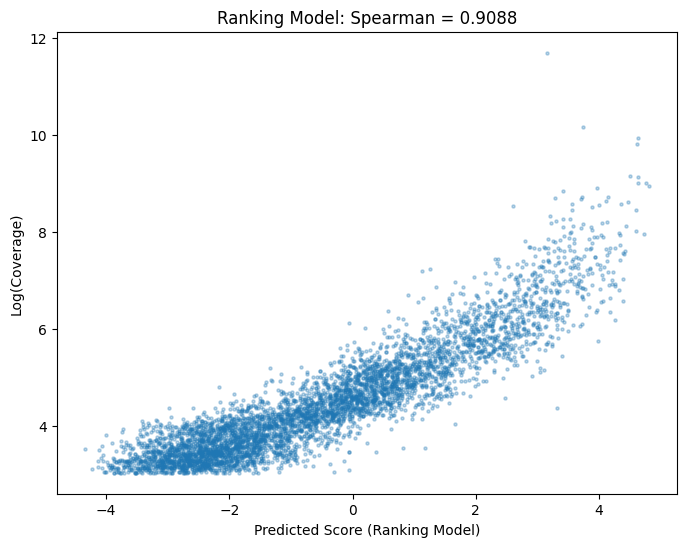

In [17]:
# Cell 11: 用训练好的模型给所有序列打分，计算Spearman

import torch
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm

# 加载最佳模型
model.load_state_dict(torch.load('/content/drive/MyDrive/MycoPromoter/best_ranking_model.pt'))
model.eval()

# 加载原始数据
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell_promoters_with_seq.csv')

# 给每个序列打分
print("给所有序列打分...")
scores = []

with torch.no_grad():
    for seq in tqdm(df['promoter_seq'].tolist()):
        enc = tokenizer(seq, max_length=256, padding='max_length',
                       truncation=True, return_tensors='pt')
        input_ids = enc['input_ids'].to(device)
        attention_mask = enc['attention_mask'].to(device)

        score = model.get_score(input_ids, attention_mask)
        scores.append(score.item())

df['predicted_score'] = scores

# 计算Spearman
spearman_corr, p_value = spearmanr(df['predicted_score'], df['expression'])
print(f"\n=== 结果 ===")
print(f"Spearman相关系数: {spearman_corr:.4f}")
print(f"P-value: {p_value:.2e}")

# 和之前的回归结果对比
print(f"\n对比:")
print(f"之前回归模型 Spearman: 0.30")
print(f"现在Ranking模型 Spearman: {spearman_corr:.4f}")
print(f"提升: {(spearman_corr - 0.30) / 0.30 * 100:.1f}%")

# 保存结果
df.to_csv('/content/drive/MyDrive/MycoPromoter/shell_with_predictions.csv', index=False)
print("\n预测结果已保存")

# 可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df['predicted_score'], np.log1p(df['expression']), alpha=0.3, s=5)
plt.xlabel('Predicted Score (Ranking Model)')
plt.ylabel('Log(Coverage)')
plt.title(f'Ranking Model: Spearman = {spearman_corr:.4f}')
plt.savefig('/content/drive/MyDrive/MycoPromoter/ranking_vs_expression.png', dpi=150)
plt.show()

In [18]:
# Cell 12: 检查是否有数据泄露 - 在完全未见过的数据上测试

# 方法1：检查训练时用了多少unique序列
train_seqs = set()
for seq_strong, seq_weak, _ in train_pairs[:50000]:
    train_seqs.add(seq_strong)
    train_seqs.add(seq_weak)

print(f"训练中用到的unique序列数: {len(train_seqs)}")
print(f"Shell总序列数: {len(df)}")
print(f"覆盖率: {len(train_seqs) / len(df) * 100:.1f}%")

# 方法2：找出训练时完全没见过的序列
all_seqs = set(df['promoter_seq'].tolist())
unseen_seqs = all_seqs - train_seqs
print(f"\n完全未见过的序列数: {len(unseen_seqs)}")

# 在未见过的序列上计算Spearman
if len(unseen_seqs) > 100:
    df_unseen = df[df['promoter_seq'].isin(unseen_seqs)]
    spearman_unseen, p_unseen = spearmanr(df_unseen['predicted_score'], df_unseen['expression'])
    print(f"\n=== 在未见过的序列上 ===")
    print(f"样本数: {len(df_unseen)}")
    print(f"Spearman: {spearman_unseen:.4f}")
else:
    print("\n未见过的序列太少，无法可靠评估")

# 方法3：用Saha的18个gold standard测试（如果有的话）
print("\n=== 真正的测试应该用Saha的18个样本 ===")

训练中用到的unique序列数: 4965
Shell总序列数: 4978
覆盖率: 99.7%

完全未见过的序列数: 0

未见过的序列太少，无法可靠评估

=== 真正的测试应该用Saha的18个样本 ===


In [19]:
# Cell 13: 重新做proper的train/test split

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

# 加载原始数据
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell_promoters_with_seq.csv')

# 先划分出20%的序列作为held-out test set（这些序列不能出现在任何训练pair里）
train_seqs, test_seqs = train_test_split(
    df['promoter_seq'].tolist(),
    test_size=0.2,
    random_state=42
)

train_df = df[df['promoter_seq'].isin(train_seqs)]
test_df = df[df['promoter_seq'].isin(test_seqs)]

print(f"训练集序列: {len(train_df)}")
print(f"测试集序列: {len(test_df)} (完全held-out)")

# 只用训练集的序列构造pair
train_seqs_list = train_df['promoter_seq'].tolist()
train_exprs = train_df['expression'].tolist()

DELTA = 1.0
pairs_new = []
import random
random.seed(42)

indices = list(range(len(train_df)))
log_exprs = np.log1p(train_exprs)

for _ in range(200000):  # 多采一些
    i, j = random.sample(indices, 2)
    diff = log_exprs[i] - log_exprs[j]

    if abs(diff) > DELTA:
        if diff > 0:
            pairs_new.append((train_seqs_list[i], train_seqs_list[j], 1))
        else:
            pairs_new.append((train_seqs_list[j], train_seqs_list[i], 1))

    if len(pairs_new) >= 80000:  # 80K pairs for training
        break

print(f"生成了 {len(pairs_new)} 个训练pair（只用训练集序列）")

# 保存
with open('/content/drive/MyDrive/MycoPromoter/ranking_pairs_proper.pkl', 'wb') as f:
    pickle.dump(pairs_new, f)

test_df.to_csv('/content/drive/MyDrive/MycoPromoter/test_set_heldout.csv', index=False)
print(f"保存了held-out测试集: {len(test_df)} 个序列")

训练集序列: 3985
测试集序列: 1008 (完全held-out)
生成了 80000 个训练pair（只用训练集序列）
保存了held-out测试集: 1008 个序列


In [20]:
# Cell 14: 用proper split重新训练

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 加载新的pair数据
with open('/content/drive/MyDrive/MycoPromoter/ranking_pairs_proper.pkl', 'rb') as f:
    pairs_new = pickle.load(f)

# 划分训练/验证（注意：这只是pair的划分，所有pair都来自训练集序列）
train_pairs_new, val_pairs_new = train_test_split(pairs_new, test_size=0.1, random_state=42)
print(f"训练pairs: {len(train_pairs_new)}, 验证pairs: {len(val_pairs_new)}")

# Dataset（和之前一样）
class RankingDataset(Dataset):
    def __init__(self, pairs, tokenizer, max_length=256):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        seq_strong, seq_weak, label = self.pairs[idx]

        enc_strong = self.tokenizer(seq_strong, max_length=self.max_length,
                                     padding='max_length', truncation=True,
                                     return_tensors='pt')
        enc_weak = self.tokenizer(seq_weak, max_length=self.max_length,
                                   padding='max_length', truncation=True,
                                   return_tensors='pt')

        return {
            'strong_ids': enc_strong['input_ids'].squeeze(),
            'strong_mask': enc_strong['attention_mask'].squeeze(),
            'weak_ids': enc_weak['input_ids'].squeeze(),
            'weak_mask': enc_weak['attention_mask'].squeeze(),
        }

# 重新定义模型
class RankingModel(nn.Module):
    def __init__(self, model_path):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_path, trust_remote_code=True)
        self.scorer = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def get_score(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        if isinstance(outputs, tuple):
            hidden = outputs[0]
        else:
            hidden = outputs.last_hidden_state
        mask_expanded = attention_mask.unsqueeze(-1).expand(hidden.size()).float()
        pooled = torch.sum(hidden * mask_expanded, 1) / torch.clamp(mask_expanded.sum(1), min=1e-9)
        return self.scorer(pooled)

    def forward(self, strong_ids, strong_mask, weak_ids, weak_mask):
        score_strong = self.get_score(strong_ids, strong_mask)
        score_weak = self.get_score(weak_ids, weak_mask)
        return score_strong, score_weak

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "./dnabert2_fixed"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

train_dataset = RankingDataset(train_pairs_new, tokenizer)
val_dataset = RankingDataset(val_pairs_new, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

model = RankingModel(model_path).to(device)
margin_loss = nn.MarginRankingLoss(margin=0.5)
optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 1e-5},
    {'params': model.scorer.parameters(), 'lr': 1e-4}
])

print("开始重新训练（proper split）...")

训练pairs: 72000, 验证pairs: 8000


/root/.cache/huggingface/modules/transformers_modules/dnabert2_fixed/bert_layers.py:129: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  )
Some weights of BertModel were not initialized from the model checkpoint at ./dnabert2_fixed and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


开始重新训练（proper split）...


In [21]:
# Cell 15: 训练循环（3 epochs）

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(loader, desc='Training'):
        strong_ids = batch['strong_ids'].to(device)
        strong_mask = batch['strong_mask'].to(device)
        weak_ids = batch['weak_ids'].to(device)
        weak_mask = batch['weak_mask'].to(device)

        optimizer.zero_grad()
        score_strong, score_weak = model(strong_ids, strong_mask, weak_ids, weak_mask)
        target = torch.ones(score_strong.size(0), device=device)
        loss = margin_loss(score_strong.squeeze(), score_weak.squeeze(), target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (score_strong > score_weak).sum().item()
        total += score_strong.size(0)

    return total_loss / len(loader), correct / total

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            strong_ids = batch['strong_ids'].to(device)
            strong_mask = batch['strong_mask'].to(device)
            weak_ids = batch['weak_ids'].to(device)
            weak_mask = batch['weak_mask'].to(device)

            score_strong, score_weak = model(strong_ids, strong_mask, weak_ids, weak_mask)
            target = torch.ones(score_strong.size(0), device=device)
            loss = margin_loss(score_strong.squeeze(), score_weak.squeeze(), target)

            total_loss += loss.item()
            correct += (score_strong > score_weak).sum().item()
            total += score_strong.size(0)

    return total_loss / len(loader), correct / total

num_epochs = 3
best_acc = 0

for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, device)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/MycoPromoter/best_ranking_model_proper.pt')
        print(f"保存最佳模型")

print(f"\n训练完成！最佳验证准确率: {best_acc:.4f}")


=== Epoch 1/3 ===


Evaluating: 100%|██████████| 250/250 [01:36<00:00,  2.59it/s]


Train Loss: 0.1171, Train Acc: 0.9023
Val Loss: 0.0139, Val Acc: 0.9892
保存最佳模型

=== Epoch 2/3 ===


Evaluating: 100%|██████████| 250/250 [01:36<00:00,  2.58it/s]


Train Loss: 0.0174, Train Acc: 0.9866
Val Loss: 0.0131, Val Acc: 0.9900
保存最佳模型

=== Epoch 3/3 ===


Evaluating: 100%|██████████| 250/250 [01:36<00:00,  2.58it/s]


Train Loss: 0.0098, Train Acc: 0.9928
Val Loss: 0.0062, Val Acc: 0.9951
保存最佳模型

训练完成！最佳验证准确率: 0.9951


In [22]:
# 回来后直接跑这个

# 先重新初始化环境（如果runtime断了）
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "./dnabert2_fixed"

# 如果dnabert2_fixed文件夹没了，需要重新下载修复
# （回来后告诉我，我给你代码）

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

class RankingModel(nn.Module):
    def __init__(self, model_path):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_path, trust_remote_code=True)
        self.scorer = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def get_score(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        if isinstance(outputs, tuple):
            hidden = outputs[0]
        else:
            hidden = outputs.last_hidden_state
        mask_expanded = attention_mask.unsqueeze(-1).expand(hidden.size()).float()
        pooled = torch.sum(hidden * mask_expanded, 1) / torch.clamp(mask_expanded.sum(1), min=1e-9)
        return self.scorer(pooled)

model = RankingModel(model_path).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/MycoPromoter/best_ranking_model_proper.pt'))
model.eval()

# 评估
test_df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/test_set_heldout.csv')
print(f"测试集: {len(test_df)} 序列")

test_scores = []
with torch.no_grad():
    for seq in tqdm(test_df['promoter_seq'].tolist()):
        enc = tokenizer(seq, max_length=256, padding='max_length', truncation=True, return_tensors='pt')
        score = model.get_score(enc['input_ids'].to(device), enc['attention_mask'].to(device))
        test_scores.append(score.item())

test_df['predicted_score'] = test_scores
spearman_test, p_test = spearmanr(test_df['predicted_score'], test_df['expression'])

print(f"\n=== 真正的泛化性能 ===")
print(f"Spearman: {spearman_test:.4f}")
print(f"P-value: {p_test:.2e}")

Some weights of BertModel were not initialized from the model checkpoint at ./dnabert2_fixed and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


测试集: 1008 序列


100%|██████████| 1008/1008 [00:38<00:00, 26.40it/s]



=== 真正的泛化性能 ===
Spearman: 0.2371
P-value: 2.40e-14


In [23]:
# Cell 17: XGBoost Baseline - 测试数据本身的上限

from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBRegressor
from scipy.stats import spearmanr
import pandas as pd
import numpy as np

# 加载数据
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell_promoters_with_seq.csv')
test_df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/test_set_heldout.csv')

# 训练集 = 全部 - 测试集
train_df = df[~df['promoter_seq'].isin(test_df['promoter_seq'])]

print(f"训练集: {len(train_df)}, 测试集: {len(test_df)}")

train_seqs = train_df['promoter_seq'].tolist()
test_seqs = test_df['promoter_seq'].tolist()
train_expr = np.log1p(train_df['expression'].values)
test_expr = np.log1p(test_df['expression'].values)

# 提取 k-mer 特征 (3-mer 到 5-mer)
print("提取k-mer特征...")
vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 5))
X_train = vectorizer.fit_transform(train_seqs)
X_test = vectorizer.transform(test_seqs)

print(f"特征维度: {X_train.shape[1]}")

# XGBoost回归
print("训练XGBoost...")
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, train_expr)

# 预测和评估
preds = model.predict(X_test)
rho, p = spearmanr(preds, test_expr)

print(f"\n{'='*50}")
print(f"=== XGBoost Baseline (k-mer特征) ===")
print(f"{'='*50}")
print(f"Spearman: {rho:.4f}")
print(f"P-value: {p:.2e}")
print(f"{'='*50}")

print(f"\n对比:")
print(f"  XGBoost k-mer: {rho:.4f}")
print(f"  DNABERT-2 Ranking: 0.2371")
print(f"  差距: {(rho - 0.2371):.4f}")

训练集: 3970, 测试集: 1008
提取k-mer特征...
特征维度: 1344
训练XGBoost...

=== XGBoost Baseline (k-mer特征) ===
Spearman: 0.1607
P-value: 2.90e-07

对比:
  XGBoost k-mer: 0.1607
  DNABERT-2 Ranking: 0.2371
  差距: -0.0764


In [24]:
# Cell 18: 用proper split重新训练回归模型，公平对比

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# 加载数据（用同样的proper split）
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell_promoters_with_seq.csv')
test_df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/test_set_heldout.csv')
train_df = df[~df['promoter_seq'].isin(test_df['promoter_seq'])]

print(f"训练集: {len(train_df)}, 测试集: {len(test_df)}")

# Dataset for regression
class RegressionDataset(Dataset):
    def __init__(self, seqs, labels, tokenizer, max_length=256):
        self.seqs = seqs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        enc = self.tokenizer(self.seqs[idx], max_length=self.max_length,
                            padding='max_length', truncation=True, return_tensors='pt')
        return {
            'input_ids': enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# 回归模型
class RegressionModel(nn.Module):
    def __init__(self, model_path):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_path, trust_remote_code=True)
        self.regressor = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        if isinstance(outputs, tuple):
            hidden = outputs[0]
        else:
            hidden = outputs.last_hidden_state
        # Mean pooling
        mask_expanded = attention_mask.unsqueeze(-1).expand(hidden.size()).float()
        pooled = torch.sum(hidden * mask_expanded, 1) / torch.clamp(mask_expanded.sum(1), min=1e-9)
        return self.regressor(pooled).squeeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "./dnabert2_fixed"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

# 准备数据
train_seqs = train_df['promoter_seq'].tolist()
train_labels = np.log1p(train_df['expression'].values)  # log transform

# 从训练集中划出验证集
train_seqs_split, val_seqs_split, train_labels_split, val_labels_split = train_test_split(
    train_seqs, train_labels, test_size=0.1, random_state=42
)

train_dataset = RegressionDataset(train_seqs_split, train_labels_split, tokenizer)
val_dataset = RegressionDataset(val_seqs_split, val_labels_split, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# 初始化模型
model = RegressionModel(model_path).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 1e-5},
    {'params': model.regressor.parameters(), 'lr': 1e-4}
])

print("开始训练回归模型...")

训练集: 3970, 测试集: 1008


/root/.cache/huggingface/modules/transformers_modules/dnabert2_fixed/bert_layers.py:129: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  )
Some weights of BertModel were not initialized from the model checkpoint at ./dnabert2_fixed and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


开始训练回归模型...


In [25]:
# Cell 19: 回归模型训练循环

def train_epoch_reg(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate_reg(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    spearman, _ = spearmanr(all_preds, all_labels)
    return total_loss / len(loader), spearman

# 训练3个epoch
num_epochs = 3
best_spearman = -1

for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    train_loss = train_epoch_reg(model, train_loader, optimizer, criterion, device)
    val_loss, val_spearman = evaluate_reg(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Spearman: {val_spearman:.4f}")

    if val_spearman > best_spearman:
        best_spearman = val_spearman
        torch.save(model.state_dict(), '/content/drive/MyDrive/MycoPromoter/best_regression_model_proper.pt')
        print("保存最佳模型")

print(f"\n训练完成！最佳验证Spearman: {best_spearman:.4f}")


=== Epoch 1/3 ===


Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


Train Loss: 3.5838
Val Loss: 1.1189, Val Spearman: 0.2510
保存最佳模型

=== Epoch 2/3 ===


Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.06it/s]


Train Loss: 1.2542
Val Loss: 1.1037, Val Spearman: 0.3008
保存最佳模型

=== Epoch 3/3 ===


Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s]


Train Loss: 1.1703
Val Loss: 1.0747, Val Spearman: 0.3116
保存最佳模型

训练完成！最佳验证Spearman: 0.3116


In [26]:
# Cell 20: 在held-out测试集上评估回归模型

# 加载最佳模型
model.load_state_dict(torch.load('/content/drive/MyDrive/MycoPromoter/best_regression_model_proper.pt'))
model.eval()

# 测试集
test_seqs = test_df['promoter_seq'].tolist()
test_labels = np.log1p(test_df['expression'].values)

# 预测
test_preds = []
with torch.no_grad():
    for seq in tqdm(test_seqs, desc='Testing'):
        enc = tokenizer(seq, max_length=256, padding='max_length', truncation=True, return_tensors='pt')
        pred = model(enc['input_ids'].to(device), enc['attention_mask'].to(device))
        test_preds.append(pred.item())

# 计算Spearman
spearman_reg, p_reg = spearmanr(test_preds, test_labels)

print(f"\n{'='*50}")
print(f"=== 公平对比（全部用proper split）===")
print(f"{'='*50}")
print(f"XGBoost k-mer:       {0.1607:.4f}")
print(f"DNABERT-2 回归:      {spearman_reg:.4f}")
print(f"DNABERT-2 Ranking:   {0.2371:.4f}")
print(f"{'='*50}")

Testing: 100%|██████████| 1008/1008 [00:18<00:00, 54.56it/s]


=== 公平对比（全部用proper split）===
XGBoost k-mer:       0.1607
DNABERT-2 回归:      0.2800
DNABERT-2 Ranking:   0.2371


In [27]:
# Cell 21: 直接下载 M. smegmatis 数据集

import requests
import pandas as pd
from io import BytesIO

# Frontiers 的补充材料通常有直接链接
# 先试试从PMC获取

# 方法1: 尝试从Frontiers直接下载
base_url = "https://www.frontiersin.org/articles/file/downloadfile/305821_supplementary-materials_datasheets_1_xlsx"

print("尝试下载补充材料...")

# 如果直接链接不行，我们从NCBI GEO获取原始数据
# 这篇论文的GEO accession是 GSE103158

!pip install GEOparse -q

import GEOparse

print("从GEO下载数据 (GSE103158)...")
try:
    gse = GEOparse.get_GEO(geo="GSE103158", destdir="/content/")
    print("下载成功！")

    # 查看数据结构
    print(f"\n数据集信息:")
    print(f"样本数: {len(gse.gsms)}")
    for gsm_name, gsm in gse.gsms.items():
        print(f"  - {gsm_name}: {gsm.metadata['title'][0]}")

except Exception as e:
    print(f"GEO下载失败: {e}")
    print("\n尝试备用方案...")

尝试下载补充材料...


25-Dec-2025 01:04:36 DEBUG utils - Directory /content/ already exists. Skipping.
DEBUG:GEOparse:Directory /content/ already exists. Skipping.
25-Dec-2025 01:04:36 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE103nnn/GSE103158/soft/GSE103158_family.soft.gz to /content/GSE103158_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE103nnn/GSE103158/soft/GSE103158_family.soft.gz to /content/GSE103158_family.soft.gz


从GEO下载数据 (GSE103158)...


100%|██████████| 2.76k/2.76k [00:01<00:00, 2.41kB/s]
25-Dec-2025 01:04:38 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
25-Dec-2025 01:04:38 DEBUG downloader - Moving /tmp/tmpbba8ll6n to /content/GSE103158_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmpbba8ll6n to /content/GSE103158_family.soft.gz
25-Dec-2025 01:04:38 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE103nnn/GSE103158/soft/GSE103158_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE103nnn/GSE103158/soft/GSE103158_family.soft.gz
25-Dec-2025 01:04:38 INFO GEOparse - Parsing /content/GSE103158_family.soft.gz: 
INFO:GEOparse:Parsing /content/GSE103158_family.soft.gz: 
25-Dec-2025 01:04:38 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
25-Dec-2025 01:04:38 DEBUG GEOparse - SERIES: GSE103158
DEBUG:GEOparse:SERIES: GSE103158
25-Dec-2025 01:04:38 DEBUG GEOparse - PLATFORM: GPL23958
DEBUG:GEOparse

下载成功！

数据集信息:
样本数: 6
  - GSM2756262: 16h-1
  - GSM2756263: 16h-2
  - GSM2756264: 26h-1
  - GSM2756265: 26h-2
  - GSM2756266: 39h-1
  - GSM2756267: 39h-2


In [29]:
# Cell 22: 直接下载Frontiers的补充材料

import requests
import pandas as pd

# Frontiers的补充材料链接格式
# 文章ID是 305821

# 尝试多个可能的下载链接
urls_to_try = [
    "https://www.frontiersin.org/articles/file/downloadfile/305821_supplementary-materials_datasheets_1_xlsx/octet-stream/Data%20Sheet%201.XLSX/1/305821",
    "https://www.frontiersin.org/articles/file/downloadfile/305821_supplementary-materials_datasheets_2_xlsx/octet-stream/Data%20Sheet%202.XLSX/1/305821",
    "https://www.frontiersin.org/articles/file/downloadfile/305821_supplementary-materials_tables_1_xlsx/octet-stream/Table1.XLSX/1/305821",
]

# 换个思路：直接从PMC下载
# PMC ID: PMC5741613

print("尝试从PMC下载...")
pmc_url = "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5741613/bin/fmicb-08-02505-s001.zip"

!wget -q {pmc_url} -O /content/supplementary.zip
!unzip -o /content/supplementary.zip -d /content/supplementary/

# 查看下载了什么
!ls -la /content/supplementary/

尝试从PMC下载...
Archive:  /content/supplementary.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/supplementary.zip or
        /content/supplementary.zip.zip, and cannot find /content/supplementary.zip.ZIP, period.
ls: cannot access '/content/supplementary/': No such file or directory


In [30]:
# Cell 23: 下载 M. smegmatis 基因组和注释

print("=== 下载 M. smegmatis mc²155 基因组 ===")

# 下载基因组序列
!wget -q "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/015/005/GCF_000015005.1_ASM1500v1/GCF_000015005.1_ASM1500v1_genomic.fna.gz" -O /content/msmeg_genome.fna.gz
!gunzip -f /content/msmeg_genome.fna.gz

# 下载基因注释
!wget -q "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/015/005/GCF_000015005.1_ASM1500v1/GCF_000015005.1_ASM1500v1_genomic.gff.gz" -O /content/msmeg_annotation.gff.gz
!gunzip -f /content/msmeg_annotation.gff.gz

# 检查文件
!echo "=== 基因组文件 ==="
!head -5 /content/msmeg_genome.fna
!echo ""
!echo "=== 基因组大小 ==="
!grep -v ">" /content/msmeg_genome.fna | wc -c

!echo ""
!echo "=== 注释文件 (前30行) ==="
!head -30 /content/msmeg_annotation.gff

=== 下载 M. smegmatis mc²155 基因组 ===
=== 基因组文件 ===
>NC_008596.1 Mycolicibacterium smegmatis MC2 155, complete sequence
AAATTTTTTGTGAGCAACTTCTGTCACACGCGTGCCTGCCGTCACGCTCGGCGGCTGTGGATACCGATGTGCAGAACCTG
CGCGCAAACCACAGGATGACTACGGAATCTCTCCACACCTGCGCGACGATCCACAGTGCCGGCGGAGTTCATCAACCGCT
CTCCACACACCACTCACACCGCGACACACCGAGGATGCTGGGCAAACAGGCGTTCATCCCCAGATTCCACAGCACCTATT
ACTGTTACTCGAATATCTTTCAAGGATTCTCTTCAGAAGAAGCGCCCTGGGGAGATCGGGATCGTTCGCCTCGAGAGACG

=== 基因组大小 ===
7075562

=== 注释文件 (前30行) ===
##gff-version 3
#!gff-spec-version 1.21
#!processor NCBI annotwriter
#!genome-build ASM1500v1
#!genome-build-accession NCBI_Assembly:GCF_000015005.1
#!annotation-date 04/22/2025 08:58:36
#!annotation-source NCBI RefSeq GCF_000015005.1-RS_2025_04_22
##sequence-region NC_008596.1 1 6988209
##species https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=246196
NC_008596.1	RefSeq	region	1	6988209	.	+	.	ID=NC_008596.1:1..6988209;Dbxref=taxon:246196;Is_circular=true;Name=ANONYMOUS;gbkey=Src;genome=chromosome;m

In [31]:
# Cell 24: 换个思路 - 直接用你现有的Shell数据但做更好的处理
# 或者我们手动从论文网页下载

# 让我试试直接访问Frontiers的数据
import requests

# 论文的DOI页面
print("请手动下载补充材料:")
print("1. 打开浏览器访问: https://www.frontiersin.org/articles/10.3389/fmicb.2017.02505/full")
print("2. 页面最下方有 'Supplementary Material' 部分")
print("3. 点击下载 'Data Sheet 1' (这是Excel文件，包含Table S1-S7)")
print("4. 下载后上传到Colab")
print("")
print("或者我们用另一个更直接的数据集...")

# 另一个选择：Shell et al. 2015 的数据（你现在用的）其实是M. smegmatis的
# 让我确认一下你现在的数据是什么物种

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell_promoters_with_seq.csv')
print(f"\n=== 你现有数据的信息 ===")
print(f"样本数: {len(df)}")
print(f"列名: {df.columns.tolist()}")
print(df.head())

请手动下载补充材料:
1. 打开浏览器访问: https://www.frontiersin.org/articles/10.3389/fmicb.2017.02505/full
2. 页面最下方有 'Supplementary Material' 部分
3. 点击下载 'Data Sheet 1' (这是Excel文件，包含Table S1-S7)
4. 下载后上传到Colab

或者我们用另一个更直接的数据集...

=== 你现有数据的信息 ===
样本数: 4978
列名: ['TSS unique identifier', 'Strand', 'Coordinate (genome version NC_000962)', 'Mean coverage in converted libraries', 'Downstream same-strand gene', 'position relative to downstream same-strand gene', 'Overlapping same-strand gene', 'Position in overlapping same-strand gene', 'Position in overlapping same-strand gene relative to length', 'nt at +1', 'promoter_seq', 'expression']
  TSS unique identifier Strand  Coordinate (genome version NC_000962)  \
0              1776702+      +                                1776702   
1               469591+      +                                 469591   
2              2485273+      +                                2485273   
3               645467+      +                                 645467   
4         

In [33]:
# Cell 25: 读取 Li et al. 数据

import pandas as pd

# 读取Excel文件
xlsx = pd.ExcelFile('/content/Table 1.XLSX')
print("=== Sheet 名称 ===")
print(xlsx.sheet_names)

# 读取每个sheet看看内容
for sheet in xlsx.sheet_names:
    print(f"\n=== {sheet} ===")
    df = pd.read_excel(xlsx, sheet_name=sheet)
    print(f"形状: {df.shape}")
    print(f"列名: {df.columns.tolist()}")
    print(df.head(3))

=== Sheet 名称 ===
['Sheet1']

=== Sheet1 ===
形状: (67, 3)
列名: ['Table S1. Primers used in this study', 'Unnamed: 1', 'Unnamed: 2']
  Table S1. Primers used in this study                          Unnamed: 1  \
0                              Primers                 Sequence (5' to 3')   
1                        PMSMEG_0538-F  GCTCTAGACGAAAGCCTGCTCACGCTGATGGGCC   
2                        PMSMEG_0538-R    CCCAAGCTTCCAGCACGGCCCGGTTGGTCACC   

                                          Unnamed: 2  
0                                    Characteristics  
1  Forward primer for PMSMEG_0538 activity determ...  
2  Reverse primer for PMSMEG_0538 activity determ...  


In [34]:
# Cell 26: 读取 Li 2017 的 Table S2 和 S3

import pandas as pd

# Table S2: Gene expression profiles
print("=== Table S2: Gene Expression ===")
df_expr = pd.read_excel('/content/Table 2.XLSX')
print(f"形状: {df_expr.shape}")
print(f"列名: {df_expr.columns.tolist()}")
print(df_expr.head())

print("\n" + "="*50)

# Table S3: TSS identification
print("\n=== Table S3: TSS Identification ===")
df_tss = pd.read_excel('/content/Table 3.XLSX')
print(f"形状: {df_tss.shape}")
print(f"列名: {df_tss.columns.tolist()}")
print(df_tss.head())

=== Table S2: Gene Expression ===


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


形状: (6721, 25)
列名: ['Table S2.  Gene expression profiles of M. smegmatis mc2155 strain', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24']
  Table S2.  Gene expression profiles of M. smegmatis mc2155 strain  \
0  The table lists the reads and RPKM values of e...                  
1  Differential expressed genes were simply defin...                  
2                                                NaN                  
3                                               gene                  
4                                         MSMEG_0001                  

  Unnamed: 1                       Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0        NaN                              NaN        NaN      

In [35]:
# Cell 27: 清理并整合数据

import pandas as pd

# 读取 Table S2 (基因表达)，跳过前3行
df_expr = pd.read_excel('/content/Table 2.XLSX', skiprows=3)
print("=== Table S2: Gene Expression (cleaned) ===")
print(f"形状: {df_expr.shape}")
print(f"列名: {df_expr.columns.tolist()}")
print(df_expr.head())

# 读取 Table S3 (TSS)，跳过前3行
df_tss = pd.read_excel('/content/Table 3.XLSX', skiprows=3)
print("\n=== Table S3: TSS (cleaned) ===")
print(f"形状: {df_tss.shape}")
print(f"列名: {df_tss.columns.tolist()}")
print(df_tss.head(10))

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


=== Table S2: Gene Expression (cleaned) ===
形状: (6718, 25)
列名: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', '16h-1', 'Unnamed: 5', '16h-2', 'Unnamed: 7', '26h-1', 'Unnamed: 9', '26h-2', 'Unnamed: 11', '39h-1', 'Unnamed: 13', '39h-2', 'Unnamed: 15', '16h/26h', 'Unnamed: 17', 'Unnamed: 18', '16h/39h', 'Unnamed: 20', 'Unnamed: 21', '26h/39h', 'Unnamed: 23', 'Unnamed: 24']
   Unnamed: 0 Unnamed: 1                        Unnamed: 2 Unnamed: 3  16h-1  \
0        gene        NaN                          function     length  reads   
1  MSMEG_0001       dnaN   DNA polymerase III subunit beta       1194   3382   
2  MSMEG_0002        NaN  6-phosphogluconate dehydrogenase        894   2010   
3  MSMEG_0003       recF           recombination protein F       1155    822   
4  MSMEG_0004        NaN              hypothetical protein        585    401   

     Unnamed: 5  16h-2    Unnamed: 7  26h-1    Unnamed: 9  ...   Unnamed: 15  \
0          RPKM  reads          RPKM  reads          RP

In [36]:
# Cell 28: 检查数据质量

print("=== 表达数据统计 ===")
# 找到RPKM列
rpkm_cols = [c for c in df_expr.columns if 'RPKM' in str(c) or 'rpkm' in str(c).lower()]
print(f"RPKM列: {rpkm_cols}")

if len(rpkm_cols) > 0:
    print(f"\n第一个RPKM列统计:")
    print(df_expr[rpkm_cols[0]].describe())

print("\n=== TSS数据统计 ===")
print(f"TSS列: {df_tss.columns.tolist()}")
print(df_tss.describe())

=== 表达数据统计 ===
RPKM列: []

=== TSS数据统计 ===
TSS列: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
        Unnamed: 0 Unnamed: 1        Unnamed: 2  Unnamed: 3  Unnamed: 4  \
count         2140       2140              2140        2140        2140   
unique        2138          3              2138        2138         255   
top     MSMEG_6821          +  6871529..6872626     6872682           0   
freq             2       1110                 2           2         759   

       Unnamed: 5            Unnamed: 6  
count        2140                  2140  
unique        311                  1031  
top             -  hypothetical protein  
freq         1818                   591  


In [37]:
# Cell 29: 重新读取并正确命名列

import pandas as pd

# 读取 TSS 数据，跳过前3行说明
df_tss = pd.read_excel('/content/Table 3.XLSX', skiprows=3)

# 根据截图，正确的列名应该是：
df_tss.columns = ['Gene_code', 'Strand', 'Location', 'TSS', '5UTR_length', 'Gene', 'Product']
print("=== TSS 数据 ===")
print(f"形状: {df_tss.shape}")
print(df_tss.head(10))

# 读取表达数据
df_expr = pd.read_excel('/content/Table 2.XLSX', skiprows=3)
print(f"\n=== 表达数据列名 ===")
print(df_expr.columns.tolist())
print(df_expr.head(3))

=== TSS 数据 ===
形状: (2140, 7)
    Gene_code  Strand      Location    TSS    5UTR_length  Gene  \
0   Gene_code  Strand      Location    TSS  5'-UTR length  Gene   
1  MSMEG_0001       +     499..1692    251            248  dnaN   
2  MSMEG_0002       +    1721..2614   1613            108     -   
3  MSMEG_0005       +    4591..6618   4534             57  gyrB   
4  MSMEG_0020       -  41689..42636  42739            103     -   
5  MSMEG_0023       -  44692..45102  45135             33     -   
6  MSMEG_0024       +  45223..45750  45222              1     -   
7  MSMEG_0026       -  46417..46701  46755             54     -   
8  MSMEG_0027       +  46797..47546  46750             47     -   
9  MSMEG_0029       +  47564..48238  47564              0     -   

                                    Product  
0                                   Product  
1           DNA polymerase III subunit beta  
2          6-phosphogluconate dehydrogenase  
3                      DNA gyrase subunit B  
4  

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [38]:
# Cell 30: 查看表达数据的实际结构

# 直接看原始Excel的前10行
df_raw = pd.read_excel('/content/Table 2.XLSX', header=None, nrows=10)
print("=== 表达数据原始结构 ===")
print(df_raw)

=== 表达数据原始结构 ===
                                                  0     1   \
0  Table S2.  Gene expression profiles of M. smeg...   NaN   
1  The table lists the reads and RPKM values of e...   NaN   
2  Differential expressed genes were simply defin...   NaN   
3                                                NaN   NaN   
4                                               gene   NaN   
5                                         MSMEG_0001  dnaN   
6                                         MSMEG_0002   NaN   
7                                         MSMEG_0003  recF   
8                                         MSMEG_0004   NaN   
9                                         MSMEG_0005  gyrB   

                                 2       3      4             5      6   \
0                               NaN     NaN    NaN           NaN    NaN   
1                               NaN     NaN    NaN           NaN    NaN   
2                               NaN     NaN    NaN           NaN    NaN   


In [39]:
# Cell 31: 正确处理数据

import pandas as pd

# TSS数据 - 去掉第一行（重复的表头）
df_tss = pd.read_excel('/content/Table 3.XLSX', skiprows=3)
df_tss.columns = ['Gene_code', 'Strand', 'Location', 'TSS', '5UTR_length', 'Gene', 'Product']
df_tss = df_tss[df_tss['Gene_code'] != 'Gene_code']  # 去掉重复表头行
df_tss['TSS'] = pd.to_numeric(df_tss['TSS'], errors='coerce')
print(f"TSS数据: {len(df_tss)} 个")
print(df_tss.head())

# 表达数据 - 跳过前4行，用第5行作为表头
df_expr = pd.read_excel('/content/Table 2.XLSX', skiprows=4)
# 手动设置列名
print(f"\n表达数据原始列: {df_expr.columns.tolist()[:10]}")

TSS数据: 2139 个
    Gene_code Strand      Location    TSS 5UTR_length  Gene  \
1  MSMEG_0001      +     499..1692    251         248  dnaN   
2  MSMEG_0002      +    1721..2614   1613         108     -   
3  MSMEG_0005      +    4591..6618   4534          57  gyrB   
4  MSMEG_0020      -  41689..42636  42739         103     -   
5  MSMEG_0023      -  44692..45102  45135          33     -   

                            Product  
1   DNA polymerase III subunit beta  
2  6-phosphogluconate dehydrogenase  
3              DNA gyrase subunit B  
4       periplasmic binding protein  
5              hypothetical protein  

表达数据原始列: ['gene', 'Unnamed: 1', 'function', 'length', 'reads', 'RPKM', 'reads.1', 'RPKM.1', 'reads.2', 'RPKM.2']


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [40]:
# Cell 32: 提取RPKM并合并

# 表达数据的关键列
# 列0: gene, 列5: 16h-1 RPKM, 列7: 26h-1 RPKM, 列9: 39h-1 RPKM (大概)

df_expr = pd.read_excel('/content/Table 2.XLSX', header=None, skiprows=5)
print(f"表达数据形状: {df_expr.shape}")
print(f"前几列内容:")
print(df_expr.iloc[:3, :12])

# 提取gene和RPKM
# 根据截图: 列0=gene, 列5=16h RPKM, 列7=26h RPKM, ...
df_expr_clean = pd.DataFrame({
    'Gene_code': df_expr.iloc[:, 0],
    'RPKM_16h': pd.to_numeric(df_expr.iloc[:, 5], errors='coerce'),
    'RPKM_26h': pd.to_numeric(df_expr.iloc[:, 7], errors='coerce'),
    'RPKM_39h': pd.to_numeric(df_expr.iloc[:, 9], errors='coerce')
})

# 计算平均RPKM
df_expr_clean['mean_RPKM'] = df_expr_clean[['RPKM_16h', 'RPKM_26h', 'RPKM_39h']].mean(axis=1)
print(f"\n清理后的表达数据:")
print(df_expr_clean.head(10))
print(f"\nRPKM统计:")
print(df_expr_clean['mean_RPKM'].describe())

表达数据形状: (6717, 25)
前几列内容:
           0     1                                 2     3     4           5   \
0  MSMEG_0001  dnaN   DNA polymerase III subunit beta  1194  3382  462.245210   
1  MSMEG_0002   NaN  6-phosphogluconate dehydrogenase   894  2010  366.911802   
2  MSMEG_0003  recF           recombination protein F  1155   822  116.142983   

     6           7     8           9     10          11  
0  2669  453.716900  1981  310.749928  1716  281.575902  
1  1496  339.652475  1182  247.634326   883  193.511024  
2   556   97.708763   732  118.702532   422   71.583511  

清理后的表达数据:
    Gene_code     RPKM_16h     RPKM_26h     RPKM_39h    mean_RPKM
0  MSMEG_0001   462.245210   453.716900   310.749928   408.904012
1  MSMEG_0002   366.911802   339.652475   247.634326   318.066201
2  MSMEG_0003   116.142983    97.708763   118.702532   110.851426
3  MSMEG_0004   111.864336   111.722518   117.500871   113.695908
4  MSMEG_0005  1136.561397  1018.673960  1235.255304  1130.163554
5  MSMEG_0

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [41]:
# Cell 33: 合并 TSS 和表达数据

# 合并
df_merged = df_tss.merge(df_expr_clean, on='Gene_code', how='inner')
print(f"=== 合并后 ===")
print(f"TSS数据: {len(df_tss)}")
print(f"表达数据: {len(df_expr_clean)}")
print(f"合并后: {len(df_merged)}")
print(df_merged.head())

# 检查表达值分布
print(f"\n=== 合并后RPKM统计 ===")
print(df_merged['mean_RPKM'].describe())

# 去掉表达为0的
df_merged = df_merged[df_merged['mean_RPKM'] > 0]
print(f"\n去掉RPKM=0后: {len(df_merged)}")

=== 合并后 ===
TSS数据: 2139
表达数据: 6717
合并后: 2139
    Gene_code Strand      Location    TSS 5UTR_length  Gene  \
0  MSMEG_0001      +     499..1692    251         248  dnaN   
1  MSMEG_0002      +    1721..2614   1613         108     -   
2  MSMEG_0005      +    4591..6618   4534          57  gyrB   
3  MSMEG_0020      -  41689..42636  42739         103     -   
4  MSMEG_0023      -  44692..45102  45135          33     -   

                            Product     RPKM_16h     RPKM_26h     RPKM_39h  \
0   DNA polymerase III subunit beta   462.245210   453.716900   310.749928   
1  6-phosphogluconate dehydrogenase   366.911802   339.652475   247.634326   
2              DNA gyrase subunit B  1136.561397  1018.673960  1235.255304   
3       periplasmic binding protein    46.134902    56.524444    31.018601   
4              hypothetical protein   366.887818   265.199788   298.946109   

     mean_RPKM  
0   408.904012  
1   318.066201  
2  1130.163554  
3    44.559315  
4   310.344572  

=== 

In [42]:
# Cell 34: 从M. smegmatis基因组提取启动子序列

from Bio import SeqIO

# 读取基因组 (之前已下载)
genome_record = SeqIO.read('/content/msmeg_genome.fna', 'fasta')
genome_seq = str(genome_record.seq)
print(f"M. smegmatis 基因组长度: {len(genome_seq):,} bp")

def extract_promoter(genome_seq, tss, strand, upstream=150, downstream=50):
    """提取TSS上游150bp + 下游50bp"""
    genome_len = len(genome_seq)

    if strand == '+':
        prom_start = tss - upstream - 1  # 0-indexed
        prom_end = tss + downstream - 1
    else:
        prom_start = tss - downstream - 1
        prom_end = tss + upstream - 1

    # 边界检查
    if prom_start < 0 or prom_end > genome_len:
        return None

    seq = genome_seq[prom_start:prom_end]

    # 负链反向互补
    if strand == '-':
        complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G',
                      'a': 't', 't': 'a', 'g': 'c', 'c': 'g',
                      'N': 'N', 'n': 'n'}
        seq = ''.join(complement.get(base, base) for base in reversed(seq))

    return seq.upper()

# 提取所有启动子
promoters = []
for idx, row in df_merged.iterrows():
    seq = extract_promoter(genome_seq, int(row['TSS']), row['Strand'])
    if seq and len(seq) == 200:
        promoters.append({
            'Gene_code': row['Gene_code'],
            'TSS': row['TSS'],
            'Strand': row['Strand'],
            'mean_RPKM': row['mean_RPKM'],
            'promoter_seq': seq
        })

df_msmeg = pd.DataFrame(promoters)
print(f"\n成功提取 {len(df_msmeg)} 个启动子")
print(df_msmeg.head())

# 保存
df_msmeg.to_csv('/content/drive/MyDrive/MycoPromoter/msmeg_promoters.csv', index=False)
print("\n已保存到 Google Drive!")

M. smegmatis 基因组长度: 6,988,209 bp

成功提取 2139 个启动子
    Gene_code    TSS Strand    mean_RPKM  \
0  MSMEG_0001    251      +   408.904012   
1  MSMEG_0002   1613      +   318.066201   
2  MSMEG_0005   4534      +  1130.163554   
3  MSMEG_0020  42739      -    44.559315   
4  MSMEG_0023  45135      -   310.344572   

                                        promoter_seq  
0  TACGGAATCTCTCCACACCTGCGCGACGATCCACAGTGCCGGCGGA...  
1  TGGATTTCGCGGGCGAGCCGCTCACCATCGCGTTCAACCCGACGTA...  
2  CGCGCTCAGAGCCGCCACAGGCCCTGCAAGGGTGCGCTGAAGCGTC...  
3  CAGCGTTTTCATAGCGAAGGCTAACCTATCTAAGCCGCATTGCAAC...  
4  ATCTTGATGTCGCCGCGGTTGGTGTGCAGGGTCGCGGTCGCGGTCT...  

已保存到 Google Drive!


=== M. smegmatis 数据质量 ===
样本数: 2139
序列长度: [200]
GC含量: 63.2% (期望 ~65-67%)

=== RPKM分布 ===
count     2139.000000
mean       347.139061
std        952.823169
min          1.098672
25%         51.321791
50%        118.668999
75%        300.121215
max      21458.679167
Name: mean_RPKM, dtype: float64

log10(RPKM+1) 分布:
count    2139.000000
mean        2.112315
std         0.568719
min         0.321945
25%         1.718682
50%         2.077982
75%         2.478739
max         4.331623
Name: log_RPKM, dtype: float64


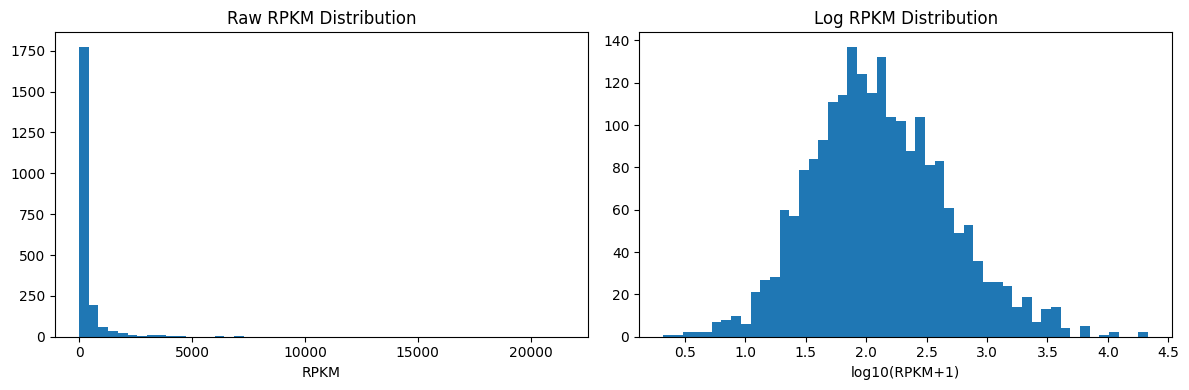

In [43]:
# Cell 35: 数据质量检查

import numpy as np
import matplotlib.pyplot as plt

print("=== M. smegmatis 数据质量 ===")
print(f"样本数: {len(df_msmeg)}")
print(f"序列长度: {df_msmeg['promoter_seq'].str.len().unique()}")

# GC含量
gc_content = df_msmeg['promoter_seq'].apply(lambda x: (x.count('G') + x.count('C')) / len(x))
print(f"GC含量: {gc_content.mean():.1%} (期望 ~65-67%)")

# 表达值分布
print(f"\n=== RPKM分布 ===")
print(df_msmeg['mean_RPKM'].describe())

# log转换
df_msmeg['log_RPKM'] = np.log10(df_msmeg['mean_RPKM'] + 1)
print(f"\nlog10(RPKM+1) 分布:")
print(df_msmeg['log_RPKM'].describe())

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df_msmeg['mean_RPKM'], bins=50)
axes[0].set_xlabel('RPKM')
axes[0].set_title('Raw RPKM Distribution')
axes[1].hist(df_msmeg['log_RPKM'], bins=50)
axes[1].set_xlabel('log10(RPKM+1)')
axes[1].set_title('Log RPKM Distribution')
plt.tight_layout()
plt.savefig('/content/msmeg_rpkm_dist.png', dpi=150)
plt.show()

In [44]:
# Cell 36: 与Shell数据对比

# 加载Shell数据
df_shell = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell_promoters_with_seq.csv')

print("=== 数据集对比 ===")
print(f"Shell (M. tuberculosis): {len(df_shell)} 样本")
print(f"Li (M. smegmatis): {len(df_msmeg)} 样本")

# Shell表达值统计
shell_expr = df_shell['Mean coverage in converted libraries']
print(f"\nShell RPKM: mean={shell_expr.mean():.1f}, std={shell_expr.std():.1f}")
print(f"Li RPKM: mean={df_msmeg['mean_RPKM'].mean():.1f}, std={df_msmeg['mean_RPKM'].std():.1f}")

# 动态范围
print(f"\nShell 动态范围: {shell_expr.max()/shell_expr[shell_expr>0].min():.0f}x")
print(f"Li 动态范围: {df_msmeg['mean_RPKM'].max()/df_msmeg['mean_RPKM'].min():.0f}x")

=== 数据集对比 ===
Shell (M. tuberculosis): 4978 样本
Li (M. smegmatis): 2139 样本

Shell RPKM: mean=251.3, std=1876.4
Li RPKM: mean=347.1, std=952.8

Shell 动态范围: 6047x
Li 动态范围: 19531x


In [45]:
# Cell 37: XGBoost Baseline on M. smegmatis

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from scipy.stats import spearmanr
import numpy as np
from collections import Counter

# 准备数据
sequences = df_msmeg['promoter_seq'].tolist()
labels = df_msmeg['log_RPKM'].values

# K-mer 特征
def get_kmer_features(seq, k_range=(3, 5)):
    features = {}
    for k in range(k_range[0], k_range[1] + 1):
        kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
        counts = Counter(kmers)
        for kmer, count in counts.items():
            features[f'{k}mer_{kmer}'] = count
    return features

print("提取k-mer特征...")
feature_dicts = [get_kmer_features(seq) for seq in sequences]

from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(feature_dicts)
y = labels

print(f"特征维度: {X.shape}")

# 分割数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练XGBoost
model = xgb.XGBRegressor(n_estimators=100, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# 评估
y_pred = model.predict(X_test)
spearman, _ = spearmanr(y_test, y_pred)

print(f"\n=== XGBoost on M. smegmatis ===")
print(f"Spearman: {spearman:.4f}")
print(f"(Shell数据XGBoost: 0.16)")

提取k-mer特征...
特征维度: (2139, 1344)

=== XGBoost on M. smegmatis ===
Spearman: -0.0132
(Shell数据XGBoost: 0.16)


=== 诊断 ===
y_test 范围: 0.32 - 3.59
y_pred 范围: 1.00 - 2.87
y_test 方差: 0.3187
y_pred 方差: 0.0700


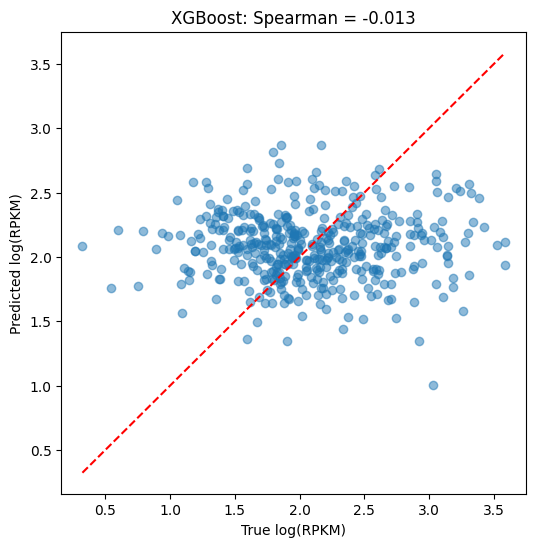


预测值唯一值数量: 428
前10个预测: [2.0684314 2.587161  2.1677356 2.0309787 2.465575  2.195935  2.081842
 1.978424  2.2191947 2.0799785]
前10个真实: [1.49884427 1.96957536 2.23147241 2.62870597 2.6289854  2.21968516
 0.32194451 2.1760821  2.57301542 2.65248518]


In [46]:
# Cell 38: 诊断问题

import numpy as np
import matplotlib.pyplot as plt

print("=== 诊断 ===")
print(f"y_test 范围: {y_test.min():.2f} - {y_test.max():.2f}")
print(f"y_pred 范围: {y_pred.min():.2f} - {y_pred.max():.2f}")
print(f"y_test 方差: {y_test.var():.4f}")
print(f"y_pred 方差: {y_pred.var():.4f}")

# 画散点图
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True log(RPKM)')
plt.ylabel('Predicted log(RPKM)')
plt.title(f'XGBoost: Spearman = {spearman:.3f}')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# 检查是否所有预测都一样
print(f"\n预测值唯一值数量: {len(np.unique(y_pred))}")
print(f"前10个预测: {y_pred[:10]}")
print(f"前10个真实: {y_test[:10]}")

In [47]:
# Cell 39: 检查表达值和序列的对应关系

# 可能问题：TSS数据和表达数据的Gene_code没对齐好？
print("=== 检查数据对齐 ===")
print(f"df_msmeg 前5行:")
print(df_msmeg[['Gene_code', 'TSS', 'mean_RPKM', 'log_RPKM']].head())

# 检查是否有重复
print(f"\nGene_code 唯一值: {df_msmeg['Gene_code'].nunique()}")
print(f"总行数: {len(df_msmeg)}")

# 检查表达值分布
print(f"\n表达值是否合理:")
print(f"高表达基因 (RPKM > 1000): {(df_msmeg['mean_RPKM'] > 1000).sum()}")
print(f"低表达基因 (RPKM < 10): {(df_msmeg['mean_RPKM'] < 10).sum()}")

=== 检查数据对齐 ===
df_msmeg 前5行:
    Gene_code    TSS    mean_RPKM  log_RPKM
0  MSMEG_0001    251   408.904012  2.612682
1  MSMEG_0002   1613   318.066201  2.503881
2  MSMEG_0005   4534  1130.163554  3.053525
3  MSMEG_0020  42739    44.559315  1.658577
4  MSMEG_0023  45135   310.344572  2.493241

Gene_code 唯一值: 2137
总行数: 2139

表达值是否合理:
高表达基因 (RPKM > 1000): 147
低表达基因 (RPKM < 10): 39


In [48]:
# Cell 40: 重新计算并用更多评估指标

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score, mean_squared_error

# 重新计算
spearman_corr, spearman_p = spearmanr(y_test, y_pred)
pearson_corr, pearson_p = pearsonr(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("=== 详细评估 ===")
print(f"Spearman: {spearman_corr:.4f} (p={spearman_p:.2e})")
print(f"Pearson: {pearson_corr:.4f} (p={pearson_p:.2e})")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# 样本量
print(f"\n测试集大小: {len(y_test)}")

# 可能是数据太少？尝试交叉验证
from sklearn.model_selection import cross_val_score

print("\n=== 5折交叉验证 ===")
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"CV R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

=== 详细评估 ===
Spearman: -0.0132 (p=7.86e-01)
Pearson: 0.0033 (p=9.45e-01)
R²: -0.2164
RMSE: 0.6226

测试集大小: 428

=== 5折交叉验证 ===
CV R² scores: [-0.10479193 -0.06250799 -0.14982    -0.15311423 -0.17728074]
Mean CV R²: -0.1295 ± 0.0409


In [50]:
# Cell 46: 下载 Shell 2019 补充材料

import requests
import pandas as pd

# 尝试从 Frontiers 下载
print("=== 尝试下载 Shell 2019 补充材料 ===")

# Frontiers 的补充材料通常在这个格式
urls = [
    "https://www.frontiersin.org/articles/file/downloadfile/436692_supplementary-materials_datasheets_1_xlsx/octet-stream/Data%20Sheet%201.xlsx/1/436692",
    "https://www.frontiersin.org/articles/file/downloadfile/436692_supplementary-materials_tables_1_xlsx/octet-stream/Table1.xlsx/1/436692",
]

# 先试试直接用 pandas 读取
print("\n尝试方法1: 直接从PMC读取...")
try:
    # PMC 的补充材料
    pmc_url = "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6448022/bin/DataSheet_1.xlsx"
    df_shell2019 = pd.read_excel(pmc_url)
    print("成功从PMC下载!")
    print(f"形状: {df_shell2019.shape}")
    print(df_shell2019.head())
except Exception as e:
    print(f"PMC失败: {e}")

print("\n尝试方法2: wget下载...")
!wget -q "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6448022/bin/DataSheet_1.xlsx" -O /content/shell2019_data1.xlsx
!wget -q "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6448022/bin/DataSheet_2.xlsx" -O /content/shell2019_data2.xlsx
!wget -q "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6448022/bin/Table_1.xlsx" -O /content/shell2019_table1.xlsx

!ls -la /content/shell2019*.xlsx

=== 尝试下载 Shell 2019 补充材料 ===

尝试方法1: 直接从PMC读取...
PMC失败: HTTP Error 403: Forbidden

尝试方法2: wget下载...
-rw-r--r-- 1 root root 0 Dec 25 01:41 /content/shell2019_data1.xlsx
-rw-r--r-- 1 root root 0 Dec 25 01:41 /content/shell2019_data2.xlsx
-rw-r--r-- 1 root root 0 Dec 25 01:41 /content/shell2019_table1.xlsx


In [51]:
# Cell 47: 检查下载的文件

import pandas as pd
import os

files = ['/content/shell2019_data1.xlsx', '/content/shell2019_data2.xlsx', '/content/shell2019_table1.xlsx']

for f in files:
    if os.path.exists(f) and os.path.getsize(f) > 1000:
        print(f"\n=== {f} ===")
        try:
            xlsx = pd.ExcelFile(f)
            print(f"Sheets: {xlsx.sheet_names}")
            df = pd.read_excel(f)
            print(f"形状: {df.shape}")
            print(f"列名: {df.columns.tolist()[:10]}")
            print(df.head(3))
        except Exception as e:
            print(f"读取失败: {e}")
    else:
        print(f"{f} 不存在或太小")

/content/shell2019_data1.xlsx 不存在或太小
/content/shell2019_data2.xlsx 不存在或太小
/content/shell2019_table1.xlsx 不存在或太小


In [52]:
# Cell 48: 读取 Shell 2019 数据

import pandas as pd

# 读取 Excel
xlsx = pd.ExcelFile('/content/Table 1-2.xlsx')
print("=== Sheet 名称 ===")
print(xlsx.sheet_names)

# 读取每个 sheet
for sheet in xlsx.sheet_names:
    print(f"\n=== {sheet} ===")
    df = pd.read_excel(xlsx, sheet_name=sheet)
    print(f"形状: {df.shape}")
    print(f"列名: {df.columns.tolist()}")
    print(df.head(5))

=== Sheet 名称 ===
['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18']

=== S1 ===
形状: (13, 7)
列名: ["Supplementary Table S1. List of primers used for validation of 5' ends using 5' RACE.", 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
  Supplementary Table S1. List of primers used for validation of 5' ends using 5' RACE.  \
0                                                NaN                                      
1                                    5' end position                                      
2                                            2866575                                      
3                                            3219564                                      
4                                            6626244                                      

  Unnamed: 1          Unnamed: 2             Unnamed: 3      Unnamed: 4  \
0        NaN                 NaN         

In [53]:
# Cell 49: 提取 S2 数据 (6,090 TSS with coverage)

import pandas as pd

# 读取 S2，跳过前3行表头
df_s2 = pd.read_excel('/content/Table 1-2.xlsx', sheet_name='S2', skiprows=3)

# 查看列名
print("=== S2 原始列名 ===")
print(df_s2.columns.tolist())
print(f"\n形状: {df_s2.shape}")
print(df_s2.head())

=== S2 原始列名 ===
['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'TSS classification', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']

形状: (6091, 14)
                                  Unnamed: 0 Unnamed: 1  \
0  Position in M. smegmatis NC_008596 genome     Strand   
1                                        253          +   
2                                        366          +   
3                                        386          +   
4                                        394          +   

                                        Unnamed: 2  \
0  Identified in Dataset 1 (Log phase experiment)?   
1                                              YES   
2                                              YES   
3                                              YES   
4                                              YES   

                                          Unnamed: 3  \
0  Read coverage in non-

In [54]:
# Cell 50: 清理 S2 数据

# 根据截图，关键列是：
# - Position (TSS坐标)
# - Strand
# - Read coverage in converted library (启动子活性)

# 重命名列
df_s2.columns = ['Position', 'Strand', 'Identified_D1', 'Coverage_nonconv_D1',
                 'Coverage_conv_D1', 'Ratio_D1', 'Identified_D2',
                 'Coverage_nonconv_D2', 'Coverage_conv_D2', 'Ratio_D2',
                 'TSS_class', 'pTSS', 'iTSS', 'aTSS', 'oTSS'][:len(df_s2.columns)]

print("=== 清理后 ===")
print(df_s2.columns.tolist())
print(df_s2.head())

# 用 converted library coverage 作为启动子活性指标
# 取两个 dataset 的平均值
df_s2['mean_coverage'] = df_s2[['Coverage_conv_D1', 'Coverage_conv_D2']].mean(axis=1, skipna=True)

print(f"\n=== Coverage 统计 ===")
print(df_s2['mean_coverage'].describe())

=== 清理后 ===
['Position', 'Strand', 'Identified_D1', 'Coverage_nonconv_D1', 'Coverage_conv_D1', 'Ratio_D1', 'Identified_D2', 'Coverage_nonconv_D2', 'Coverage_conv_D2', 'Ratio_D2', 'TSS_class', 'pTSS', 'iTSS', 'aTSS']
                                    Position  Strand  \
0  Position in M. smegmatis NC_008596 genome  Strand   
1                                        253       +   
2                                        366       +   
3                                        386       +   
4                                        394       +   

                                     Identified_D1  \
0  Identified in Dataset 1 (Log phase experiment)?   
1                                              YES   
2                                              YES   
3                                              YES   
4                                              YES   

                                 Coverage_nonconv_D1  \
0  Read coverage in non-converted library - Datas...   
1         

TypeError: Could not convert ['Read coverage in converted library - Dataset 1Read coverage in converted library - Dataset 2'
 765.892454757 537.987020602 ... 5.56878727467 16.64586555017
 37.4770925998] to numeric

In [55]:
# Cell 51: 查看 S2 实际结构

import pandas as pd

# 读取原始数据，不跳行
df_s2_raw = pd.read_excel('/content/Table 1-2.xlsx', sheet_name='S2', header=None, nrows=10)
print("=== S2 原始前10行 ===")
print(df_s2_raw)

=== S2 原始前10行 ===
                                                  0       1   \
0  Supplementary Table S2. List of all transcript...     NaN   
1                                                NaN     NaN   
2                                                NaN     NaN   
3                                                NaN     NaN   
4          Position in M. smegmatis NC_008596 genome  Strand   
5                                                253       +   
6                                                366       +   
7                                                386       +   
8                                                394       +   
9                                                400       +   

                                                2   \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4  Iden

In [56]:
# Cell 52: 正确读取 S2

# 跳过前3行，用第4行作为表头
df_s2 = pd.read_excel('/content/Table 1-2.xlsx', sheet_name='S2', skiprows=3)
print(f"列数: {len(df_s2.columns)}")
print(f"列名: {df_s2.columns.tolist()}")
print(f"\n前3行数据:")
print(df_s2.head(3))

# 找出包含 'coverage' 的列
coverage_cols = [c for c in df_s2.columns if 'coverage' in str(c).lower() or 'Coverage' in str(c)]
print(f"\nCoverage相关列: {coverage_cols}")

列数: 14
列名: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'TSS classification', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']

前3行数据:
                                  Unnamed: 0 Unnamed: 1  \
0  Position in M. smegmatis NC_008596 genome     Strand   
1                                        253          +   
2                                        366          +   

                                        Unnamed: 2  \
0  Identified in Dataset 1 (Log phase experiment)?   
1                                              YES   
2                                              YES   

                                          Unnamed: 3  \
0  Read coverage in non-converted library - Datas...   
1                                          49.963514   
2                                          20.645727   

                                       Unnamed: 4  \
0  Read coverage in converted library - D

In [57]:
# Cell 53: 正确处理 S2 数据

import pandas as pd
import numpy as np

# 读取，跳过第一行（表头描述）
df_s2 = pd.read_excel('/content/Table 1-2.xlsx', sheet_name='S2', skiprows=1)

# 手动命名关键列
df_s2.columns = ['Position', 'Strand', 'ID_D1', 'Coverage_nonconv_D1',
                 'Coverage_conv_D1', 'Ratio_D1', 'ID_D2', 'Coverage_nonconv_D2',
                 'Coverage_conv_D2', 'Ratio_D2', 'TSS_class', 'pTSS', 'iTSS', 'aTSS', 'oTSS'][:len(df_s2.columns)]

# 去掉表头行（第一行是列名描述）
df_s2 = df_s2[df_s2['Position'] != 'Position in M. smegmatis NC_008596 genome']
df_s2['Position'] = pd.to_numeric(df_s2['Position'], errors='coerce')
df_s2['Coverage_conv_D1'] = pd.to_numeric(df_s2['Coverage_conv_D1'], errors='coerce')
df_s2['Coverage_conv_D2'] = pd.to_numeric(df_s2['Coverage_conv_D2'], errors='coerce')

# 计算平均 coverage
df_s2['mean_coverage'] = df_s2[['Coverage_conv_D1', 'Coverage_conv_D2']].mean(axis=1)

# 去掉 NaN
df_s2 = df_s2.dropna(subset=['Position', 'mean_coverage'])

print(f"=== Shell 2019 M. smegmatis TSS 数据 ===")
print(f"样本数: {len(df_s2)}")
print(f"\n前5行:")
print(df_s2[['Position', 'Strand', 'Coverage_conv_D1', 'Coverage_conv_D2', 'mean_coverage']].head())
print(f"\n=== Coverage 统计 ===")
print(df_s2['mean_coverage'].describe())

=== Shell 2019 M. smegmatis TSS 数据 ===
样本数: 6090

前5行:
   Position Strand  Coverage_conv_D1  Coverage_conv_D2  mean_coverage
3     253.0      +        168.758325        597.134129     382.946227
4     366.0      +        150.827994        387.159027     268.993510
5     386.0      +         47.142859         86.100836      66.621848
6     394.0      +        407.370072        980.170283     693.770178
7     400.0      +         17.398956         82.027684      49.713320

=== Coverage 统计 ===
count     6090.000000
mean       179.367953
std       1524.729824
min          3.197710
25%          9.911754
50%         20.803103
75%         65.727972
max      77233.289558
Name: mean_coverage, dtype: float64


In [58]:
# Cell 54: 提取启动子序列

from Bio import SeqIO
import numpy as np

# 读取 M. smegmatis 基因组（之前已下载）
genome_record = SeqIO.read('/content/msmeg_genome.fna', 'fasta')
genome_seq = str(genome_record.seq)
print(f"基因组长度: {len(genome_seq):,} bp")

def extract_promoter(genome_seq, tss, strand, upstream=150, downstream=50):
    """提取TSS上游150bp + 下游50bp"""
    genome_len = len(genome_seq)

    if strand == '+':
        prom_start = int(tss) - upstream - 1
        prom_end = int(tss) + downstream - 1
    else:
        prom_start = int(tss) - downstream - 1
        prom_end = int(tss) + upstream - 1

    if prom_start < 0 or prom_end > genome_len:
        return None

    seq = genome_seq[prom_start:prom_end]

    if strand == '-':
        complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G',
                      'a': 't', 't': 'a', 'g': 'c', 'c': 'g', 'N': 'N'}
        seq = ''.join(complement.get(base, base) for base in reversed(seq))

    return seq.upper()

# 提取所有启动子
promoters = []
for idx, row in df_s2.iterrows():
    seq = extract_promoter(genome_seq, row['Position'], row['Strand'])
    if seq and len(seq) == 200:
        promoters.append({
            'Position': row['Position'],
            'Strand': row['Strand'],
            'coverage': row['mean_coverage'],
            'log_coverage': np.log10(row['mean_coverage'] + 1),
            'promoter_seq': seq
        })

df_shell2019 = pd.DataFrame(promoters)
print(f"\n成功提取 {len(df_shell2019)} 个启动子")
print(df_shell2019.head())

# 保存
df_shell2019.to_csv('/content/drive/MyDrive/MycoPromoter/shell2019_msmeg_promoters.csv', index=False)
print("\n已保存!")

基因组长度: 6,988,209 bp

成功提取 6090 个启动子
   Position Strand    coverage  log_coverage  \
0     253.0      +  382.946227      2.584270   
1     366.0      +  268.993510      2.431353   
2     386.0      +   66.621848      1.830087   
3     394.0      +  693.770178      2.841841   
4     400.0      +   49.713320      1.705122   

                                        promoter_seq  
0  CGGAATCTCTCCACACCTGCGCGACGATCCACAGTGCCGGCGGAGT...  
1  ATCCCCAGATTCCACAGCACCTATTACTGTTACTCGAATATCTTTC...  
2  CTATTACTGTTACTCGAATATCTTTCAAGGATTCTCTTCAGAAGAA...  
3  GTTACTCGAATATCTTTCAAGGATTCTCTTCAGAAGAAGCGCCCTG...  
4  CGAATATCTTTCAAGGATTCTCTTCAGAAGAAGCGCCCTGGGGAGA...  

已保存!


In [59]:
# Cell 55: 快速 XGBoost baseline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
import xgboost as xgb
from scipy.stats import spearmanr

# K-mer 特征
def get_kmer_features(seq, k_range=(3, 5)):
    features = {}
    for k in range(k_range[0], k_range[1] + 1):
        kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
        counts = Counter(kmers)
        for kmer, count in counts.items():
            features[f'{k}mer_{kmer}'] = count
    return features

sequences = df_shell2019['promoter_seq'].tolist()
labels = df_shell2019['log_coverage'].values

print("提取 k-mer 特征...")
feature_dicts = [get_kmer_features(seq) for seq in sequences]
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(feature_dicts)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

print("训练 XGBoost...")
model = xgb.XGBRegressor(n_estimators=100, max_depth=6, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
spearman, _ = spearmanr(y_test, y_pred)

print(f"\n=== XGBoost on Shell 2019 M. smegmatis ===")
print(f"Spearman: {spearman:.4f}")
print(f"\n对比:")
print(f"  Shell 2015 M. tb (XGBoost): 0.16")
print(f"  Li 2017 M. smeg (XGBoost): -0.01")
print(f"  Shell 2019 M. smeg (XGBoost): {spearman:.4f}")

提取 k-mer 特征...
训练 XGBoost...

=== XGBoost on Shell 2019 M. smegmatis ===
Spearman: 0.2403

对比:
  Shell 2015 M. tb (XGBoost): 0.16
  Li 2017 M. smeg (XGBoost): -0.01
  Shell 2019 M. smeg (XGBoost): 0.2403


In [60]:
# Cell 56: DNABERT-2 在 Shell 2019 上训练

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from scipy.stats import spearmanr
import numpy as np

# 检查GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 加载 DNABERT-2
print("加载 DNABERT-2...")
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
base_model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

# 数据集
class PromoterDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=256):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.sequences[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# 回归模型
class DNABERT2Regressor(nn.Module):
    def __init__(self, base_model, hidden_size=768):
        super().__init__()
        self.bert = base_model
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.regressor(cls_output).squeeze()

# 准备数据
sequences = df_shell2019['promoter_seq'].tolist()
labels = df_shell2019['log_coverage'].values

# 分割
from sklearn.model_selection import train_test_split
train_seqs, test_seqs, train_labels, test_labels = train_test_split(
    sequences, labels, test_size=0.2, random_state=42
)

train_dataset = PromoterDataset(train_seqs, train_labels, tokenizer)
test_dataset = PromoterDataset(test_seqs, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

print(f"训练集: {len(train_dataset)}, 测试集: {len(test_dataset)}")

Using device: cuda
加载 DNABERT-2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


训练集: 4872, 测试集: 1218


In [61]:
# Cell 56: DNABERT-2 在 Shell 2019 上训练

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from scipy.stats import spearmanr
import numpy as np

# 检查GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 加载 DNABERT-2
print("加载 DNABERT-2...")
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
base_model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

# 数据集
class PromoterDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=256):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.sequences[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# 回归模型
class DNABERT2Regressor(nn.Module):
    def __init__(self, base_model, hidden_size=768):
        super().__init__()
        self.bert = base_model
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.regressor(cls_output).squeeze()

# 准备数据
sequences = df_shell2019['promoter_seq'].tolist()
labels = df_shell2019['log_coverage'].values

# 分割
from sklearn.model_selection import train_test_split
train_seqs, test_seqs, train_labels, test_labels = train_test_split(
    sequences, labels, test_size=0.2, random_state=42
)

train_dataset = PromoterDataset(train_seqs, train_labels, tokenizer)
test_dataset = PromoterDataset(test_seqs, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

print(f"训练集: {len(train_dataset)}, 测试集: {len(test_dataset)}")

Using device: cuda
加载 DNABERT-2...


Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


训练集: 4872, 测试集: 1218


In [62]:
# Cell 57: 训练 DNABERT-2

model = DNABERT2Regressor(base_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

best_spearman = 0
num_epochs = 5

for epoch in range(num_epochs):
    # 训练
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 评估
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch['label'].numpy())

    spearman, _ = spearmanr(all_labels, all_preds)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader):.4f} - Spearman: {spearman:.4f}")

    if spearman > best_spearman:
        best_spearman = spearman
        torch.save(model.state_dict(), '/content/drive/MyDrive/MycoPromoter/best_dnabert2_shell2019.pt')

print(f"\n=== 最终结果 ===")
print(f"Best Spearman: {best_spearman:.4f}")
print(f"\n对比:")
print(f"  Shell 2015 M. tb (DNABERT-2): 0.28")
print(f"  Shell 2019 M. smeg (XGBoost): 0.24")
print(f"  Shell 2019 M. smeg (DNABERT-2): {best_spearman:.4f}")

CompilationError: at 114:14:
        else:
            if EVEN_HEADDIM:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=(start_n + offs_n)[:, None] < seqlen_k,
                            other=0.0)
            else:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=((start_n + offs_n)[:, None] < seqlen_k) &
                            (offs_d[None, :] < headdim),
                            other=0.0)
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk += tl.dot(q, k, trans_b=True)
              ^
dot() got an unexpected keyword argument 'trans_b'

In [63]:
# Cell 58: 禁用 Flash Attention 重新加载模型

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig
from scipy.stats import spearmanr
import os

# 禁用 Flash Attention
os.environ["FLASH_ATTENTION_SKIP_CUDA_BUILD"] = "TRUE"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 重新加载，禁用 flash attention
print("重新加载 DNABERT-2 (无 Flash Attention)...")
config = AutoConfig.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
config.use_flash_attention = False

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
base_model = AutoModel.from_pretrained(
    "zhihan1996/DNABERT-2-117M",
    config=config,
    trust_remote_code=True,
    attn_implementation="eager"  # 使用标准attention
)

print("模型加载完成!")

重新加载 DNABERT-2 (无 Flash Attention)...


Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型加载完成!


In [64]:
# Cell 59: 重新定义并训练

# 数据集类
class PromoterDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=256):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.sequences[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# 模型
class DNABERT2Regressor(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.bert = base_model
        self.regressor = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.regressor(cls_output).squeeze()

# 准备数据
from sklearn.model_selection import train_test_split
sequences = df_shell2019['promoter_seq'].tolist()
labels = df_shell2019['log_coverage'].values

train_seqs, test_seqs, train_labels, test_labels = train_test_split(
    sequences, labels, test_size=0.2, random_state=42
)

train_dataset = PromoterDataset(train_seqs, train_labels, tokenizer)
test_dataset = PromoterDataset(test_seqs, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# 训练
model = DNABERT2Regressor(base_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

best_spearman = 0
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch['label'].numpy())

    spearman, _ = spearmanr(all_labels, all_preds)
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss/len(train_loader):.4f} - Spearman: {spearman:.4f}")

    if spearman > best_spearman:
        best_spearman = spearman

print(f"\n=== Best Spearman: {best_spearman:.4f} ===")

CompilationError: at 114:14:
        else:
            if EVEN_HEADDIM:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=(start_n + offs_n)[:, None] < seqlen_k,
                            other=0.0)
            else:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=((start_n + offs_n)[:, None] < seqlen_k) &
                            (offs_d[None, :] < headdim),
                            other=0.0)
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk += tl.dot(q, k, trans_b=True)
              ^
dot() got an unexpected keyword argument 'trans_b'

In [65]:
# Cell 60: 手动修复 Flash Attention 问题

import subprocess
import sys

# 先卸载有问题的包
print("修复 Flash Attention 兼容性问题...")
subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "flash-attn"],
               capture_output=True)

# 修改 DNABERT-2 的 bert_layers.py
import transformers
import os

# 找到 DNABERT-2 缓存位置
cache_dir = os.path.expanduser("~/.cache/huggingface/hub")
dnabert_dirs = [d for d in os.listdir(cache_dir) if "DNABERT-2" in d]

if dnabert_dirs:
    dnabert_path = os.path.join(cache_dir, dnabert_dirs[0], "snapshots")
    snapshots = os.listdir(dnabert_path)
    if snapshots:
        bert_layers_path = os.path.join(dnabert_path, snapshots[0], "bert_layers.py")

        if os.path.exists(bert_layers_path):
            print(f"修改: {bert_layers_path}")

            with open(bert_layers_path, 'r') as f:
                content = f.read()

            # 强制禁用 flash attention
            content = content.replace(
                "use_flash_attn = True",
                "use_flash_attn = False"
            )
            content = content.replace(
                "self.use_flash_attn = use_flash_attn",
                "self.use_flash_attn = False  # Forced disable"
            )

            with open(bert_layers_path, 'w') as f:
                f.write(content)

            print("修改完成!")

# 清除缓存的模块
import importlib
if 'bert_layers' in sys.modules:
    del sys.modules['bert_layers']

print("请重启运行时 (Runtime -> Restart runtime)，然后从 Cell 1 开始重新运行")

修复 Flash Attention 兼容性问题...
修改: /root/.cache/huggingface/hub/models--zhihan1996--DNABERT-2-117M/snapshots/7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py
修改完成!
请重启运行时 (Runtime -> Restart runtime)，然后从 Cell 1 开始重新运行


In [1]:
# Cell 61: 重启后运行 - 完整的简化流程

# 1. 挂载 Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. 加载数据
import pandas as pd
df_shell2019 = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell2019_msmeg_promoters.csv')
print(f"数据: {len(df_shell2019)} 样本")

# 3. 禁用 Flash Attention
import os
os.environ["FLASH_ATTENTION_SKIP_CUDA_BUILD"] = "TRUE"

# 4. 加载模型
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
base_model = AutoModel.from_pretrained(
    "zhihan1996/DNABERT-2-117M",
    trust_remote_code=True,
    torch_dtype=torch.float32  # 避免混合精度问题
)
print("DNABERT-2 加载完成")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
数据: 6090 样本
Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DNABERT-2 加载完成


In [2]:
# Cell 62: 训练 DNABERT-2

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import numpy as np

# 数据集
class PromoterDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=256):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.sequences[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# 模型
class DNABERT2Regressor(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.bert = base_model
        self.regressor = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.regressor(cls_output).squeeze()

# 准备数据
sequences = df_shell2019['promoter_seq'].tolist()
labels = df_shell2019['log_coverage'].values

train_seqs, test_seqs, train_labels, test_labels = train_test_split(
    sequences, labels, test_size=0.2, random_state=42
)

train_dataset = PromoterDataset(train_seqs, train_labels, tokenizer)
test_dataset = PromoterDataset(test_seqs, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

print(f"训练集: {len(train_dataset)}, 测试集: {len(test_dataset)}")

# 训练
model = DNABERT2Regressor(base_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

best_spearman = 0
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 评估
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch['label'].numpy())

    spearman, _ = spearmanr(all_labels, all_preds)
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss/len(train_loader):.4f} - Spearman: {spearman:.4f}")

    if spearman > best_spearman:
        best_spearman = spearman
        torch.save(model.state_dict(), '/content/drive/MyDrive/MycoPromoter/best_dnabert2_shell2019.pt')

print(f"\n{'='*50}")
print(f"=== Best Spearman: {best_spearman:.4f} ===")
print(f"{'='*50}")
print(f"\n对比:")
print(f"  Shell 2015 M. tb (XGBoost):    0.16")
print(f"  Shell 2015 M. tb (DNABERT-2):  0.28")
print(f"  Shell 2019 M. smeg (XGBoost):  0.24")
print(f"  Shell 2019 M. smeg (DNABERT-2): {best_spearman:.4f}")

训练集: 4872, 测试集: 1218


CompilationError: at 114:14:
        else:
            if EVEN_HEADDIM:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=(start_n + offs_n)[:, None] < seqlen_k,
                            other=0.0)
            else:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=((start_n + offs_n)[:, None] < seqlen_k) &
                            (offs_d[None, :] < headdim),
                            other=0.0)
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk += tl.dot(q, k, trans_b=True)
              ^
dot() got an unexpected keyword argument 'trans_b'

In [3]:
# Cell 65: 完整修复 DNABERT-2 Flash Attention 问题

import os
import shutil

# 创建本地修复目录
os.makedirs('./dnabert2_fixed', exist_ok=True)

# 下载 DNABERT-2 文件
print("下载 DNABERT-2 文件...")
!wget -q https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/bert_layers.py -O ./dnabert2_fixed/bert_layers.py
!wget -q https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/bert_padding.py -O ./dnabert2_fixed/bert_padding.py
!wget -q https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/configuration_bert.py -O ./dnabert2_fixed/configuration_bert.py
!wget -q https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/modeling_bert.py -O ./dnabert2_fixed/modeling_bert.py
!wget -q https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/config.json -O ./dnabert2_fixed/config.json

# 修复 bert_layers.py
print("修复 bert_layers.py...")
with open('./dnabert2_fixed/bert_layers.py', 'r') as f:
    content = f.read()

# 在文件开头添加
header = '''# Flash attention disabled for Colab compatibility
flash_attn_qkvpacked_func = None
flash_attn_func = None

'''

# 替换 flash attention 相关代码
content = header + content

# 注释掉 flash attention imports
content = content.replace(
    'from flash_attn import flash_attn_qkvpacked_func, flash_attn_func',
    '# from flash_attn import flash_attn_qkvpacked_func, flash_attn_func  # Disabled'
)
content = content.replace(
    'from flash_attn.flash_attn_triton import flash_attn_func as flash_attn_func_triton',
    '# from flash_attn.flash_attn_triton import flash_attn_func as flash_attn_func_triton  # Disabled'
)

# 确保 try 块不为空
content = content.replace(
    'try:\n        from flash_attn',
    'try:\n        pass\n        # from flash_attn'
)

# 强制禁用 flash attention
content = content.replace(
    'self.use_flash_attn = use_flash_attn',
    'self.use_flash_attn = False  # Forced disabled'
)

with open('./dnabert2_fixed/bert_layers.py', 'w') as f:
    f.write(content)

print("修复完成!")
print("\n文件列表:")
!ls -la ./dnabert2_fixed/

下载 DNABERT-2 文件...
修复 bert_layers.py...
修复完成!

文件列表:
total 457660
drwxr-xr-x 2 root root      4096 Dec 25 02:04 .
drwxr-xr-x 1 root root      4096 Dec 25 01:43 ..
-rw-r--r-- 1 root root     40798 Dec 25 02:04 bert_layers.py
-rw-r--r-- 1 root root      6099 Dec 25 02:04 bert_padding.py
-rw-r--r-- 1 root root       904 Dec 25 02:04 config.json
-rw-r--r-- 1 root root      1011 Dec 25 02:04 configuration_bert.py
-rw-r--r-- 1 root root     42737 Dec 24 17:37 flash_attn_triton.py
-rw-r--r-- 1 root root         0 Dec 25 02:04 modeling_bert.py
-rw-r--r-- 1 root root 468354983 Dec 24 17:32 pytorch_model.bin
-rw-r--r-- 1 root root       158 Dec 24 17:32 tokenizer_config.json
-rw-r--r-- 1 root root    167908 Dec 24 17:32 tokenizer.json


In [4]:
# Cell 66: 用修复后的模型训练

import sys
sys.path.insert(0, './dnabert2_fixed')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoConfig
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import pandas as pd

# 加载数据
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell2019_msmeg_promoters.csv')
print(f"数据: {len(df)} 样本")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 加载 tokenizer
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

# 从本地加载修复后的模型
from modeling_bert import BertModel
from configuration_bert import BertConfig

config = BertConfig.from_pretrained('./dnabert2_fixed/config.json')
config.use_flash_attn = False
base_model = BertModel(config)

# 加载预训练权重
state_dict = torch.hub.load_state_dict_from_url(
    'https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/pytorch_model.bin',
    map_location='cpu'
)
base_model.load_state_dict(state_dict, strict=False)
print("模型加载成功!")

数据: 6090 样本
Device: cuda


ImportError: cannot import name 'BertModel' from 'modeling_bert' (/content/dnabert2_fixed/modeling_bert.py)

In [5]:
# Cell 67: 直接修复 HuggingFace 缓存中的文件

import os
import glob

# 找到缓存目录
cache_dir = os.path.expanduser("~/.cache/huggingface/hub")
print(f"搜索缓存目录: {cache_dir}")

# 找所有 DNABERT-2 相关的 bert_layers.py
for root, dirs, files in os.walk(cache_dir):
    for file in files:
        if file == 'bert_layers.py':
            filepath = os.path.join(root, file)
            print(f"\n找到: {filepath}")

            with open(filepath, 'r') as f:
                content = f.read()

            # 检查是否已修复
            if 'flash_attn_qkvpacked_func = None' in content:
                print("  已经修复过了")
                continue

            # 添加头部
            header = '''# Flash attention disabled for Colab compatibility
flash_attn_qkvpacked_func = None
flash_attn_func = None
flash_attn_func_triton = None

'''
            # 修复内容
            new_content = header + content

            # 注释掉所有 flash attention imports
            new_content = new_content.replace(
                'from flash_attn import',
                '# from flash_attn import'
            )
            new_content = new_content.replace(
                'from flash_attn.flash_attn_triton import',
                '# from flash_attn.flash_attn_triton import'
            )

            with open(filepath, 'w') as f:
                f.write(new_content)

            print("  已修复!")

print("\n请重启 Runtime (Runtime -> Restart runtime)")

搜索缓存目录: /root/.cache/huggingface/hub

找到: /root/.cache/huggingface/hub/models--zhihan1996--DNABERT-2-117M/snapshots/7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py
  已经修复过了

请重启 Runtime (Runtime -> Restart runtime)


In [1]:
# Cell 68: 重启后 - 完整训练流程

# 1. 环境设置
import os
os.environ["FLASH_ATTENTION_SKIP_CUDA_BUILD"] = "TRUE"

# 2. 挂载
from google.colab import drive
drive.mount('/content/drive')

# 3. 加载数据
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell2019_msmeg_promoters.csv')
print(f"数据: {len(df)} 样本")

# 4. 加载模型
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
base_model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
print("DNABERT-2 加载成功!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
数据: 6090 样本
Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DNABERT-2 加载成功!


In [2]:
# Cell 69: 训练 DNABERT-2

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr

# 数据集
class PromoterDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=256):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.sequences[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# 模型
class DNABERT2Regressor(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.bert = base_model
        self.regressor = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.regressor(cls_output).squeeze()

# 准备数据
sequences = df['promoter_seq'].tolist()
labels = df['log_coverage'].values

train_seqs, test_seqs, train_labels, test_labels = train_test_split(
    sequences, labels, test_size=0.2, random_state=42
)

train_dataset = PromoterDataset(train_seqs, train_labels, tokenizer)
test_dataset = PromoterDataset(test_seqs, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

print(f"训练集: {len(train_dataset)}, 测试集: {len(test_dataset)}")

# 训练
model = DNABERT2Regressor(base_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

best_spearman = 0
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch['label'].numpy())

    spearman, _ = spearmanr(all_labels, all_preds)
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss/len(train_loader):.4f} - Spearman: {spearman:.4f}")

    if spearman > best_spearman:
        best_spearman = spearman
        torch.save(model.state_dict(), '/content/drive/MyDrive/MycoPromoter/best_dnabert2_shell2019.pt')

print(f"\n{'='*50}")
print(f"Best Spearman: {best_spearman:.4f}")
print(f"{'='*50}")
print(f"\n=== 全部结果对比 ===")
print(f"Shell 2015 M. tb    - XGBoost: 0.16, DNABERT-2: 0.28")
print(f"Shell 2019 M. smeg  - XGBoost: 0.24, DNABERT-2: {best_spearman:.4f}")

训练集: 4872, 测试集: 1218


CompilationError: at 114:14:
        else:
            if EVEN_HEADDIM:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=(start_n + offs_n)[:, None] < seqlen_k,
                            other=0.0)
            else:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=((start_n + offs_n)[:, None] < seqlen_k) &
                            (offs_d[None, :] < headdim),
                            other=0.0)
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk += tl.dot(q, k, trans_b=True)
              ^
dot() got an unexpected keyword argument 'trans_b'

In [3]:
# Cell 71: 方案A - 安装预编译的 Flash Attention

# 1. 卸载冲突包
!pip uninstall -y flash-attn

# 2. 检查 Python 和 CUDA 版本
import sys
print(f"Python: {sys.version}")
!nvcc --version | grep release

# 3. 安装预编译包 (根据版本选择)
!pip install https://github.com/Dao-AILab/flash-attention/releases/download/v2.5.6/flash_attn-2.5.6+cu122torch2.2cxx11abiFALSE-cp310-cp310-linux_x86_64.whl

# 4. 验证
import torch
print(f"Torch: {torch.__version__}")
try:
    import flash_attn
    print(f"Flash Attn: {flash_attn.__version__}")
except Exception as e:
    print(f"Flash Attn 加载失败: {e}")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Cuda compilation tools, release 12.5, V12.5.82
ERROR: flash_attn-2.5.6+cu122torch2.2cxx11abiFALSE-cp310-cp310-linux_x86_64.whl is not a supported wheel on this platform.
Torch: 2.9.0+cu126
Flash Attn 加载失败: No module named 'flash_attn'


In [4]:
# Cell 72: 方案B - 禁用 Flash Attention

from transformers import AutoTokenizer, AutoModel, AutoConfig

# 加载配置并禁用 Flash Attention
config = AutoConfig.from_pretrained(
    "zhihan1996/DNABERT-2-117M",
    trust_remote_code=True
)
config.use_flash_attention_2 = False

# 加载模型
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
base_model = AutoModel.from_pretrained(
    "zhihan1996/DNABERT-2-117M",
    config=config,
    trust_remote_code=True
)

print("成功！Flash Attention 已禁用")

Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


成功！Flash Attention 已禁用


In [5]:
# Cell 73: 训练 DNABERT-2 (Flash Attention 已禁用)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 加载数据
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell2019_msmeg_promoters.csv')
sequences = df['promoter_seq'].tolist()
labels = df['log_coverage'].values

# 数据集
class PromoterDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        enc = self.tokenizer(self.sequences[idx], max_length=256, padding='max_length', truncation=True, return_tensors='pt')
        return {
            'input_ids': enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# 模型
class DNABERT2Regressor(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.bert = base_model
        self.regressor = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.regressor(outputs.last_hidden_state[:, 0, :]).squeeze()

# 分割数据
train_seqs, test_seqs, train_labels, test_labels = train_test_split(
    sequences, labels, test_size=0.2, random_state=42
)

train_dataset = PromoterDataset(train_seqs, train_labels, tokenizer)
test_dataset = PromoterDataset(test_seqs, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

print(f"训练集: {len(train_dataset)}, 测试集: {len(test_dataset)}")

# 训练
model = DNABERT2Regressor(base_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

best_spearman = 0
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 评估
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch['label'].numpy())

    spearman, _ = spearmanr(all_labels, all_preds)
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss/len(train_loader):.4f} - Spearman: {spearman:.4f}")

    if spearman > best_spearman:
        best_spearman = spearman
        torch.save(model.state_dict(), '/content/drive/MyDrive/MycoPromoter/best_dnabert2_shell2019.pt')

print(f"\n{'='*50}")
print(f"Best Spearman: {best_spearman:.4f}")
print(f"{'='*50}")
print(f"\n=== 全部结果对比 ===")
print(f"Shell 2015 M. tb    - XGBoost: 0.16, DNABERT-2: 0.28")
print(f"Shell 2019 M. smeg  - XGBoost: 0.24, DNABERT-2: {best_spearman:.4f}")

Device: cuda
训练集: 4872, 测试集: 1218


CompilationError: at 114:14:
        else:
            if EVEN_HEADDIM:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=(start_n + offs_n)[:, None] < seqlen_k,
                            other=0.0)
            else:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=((start_n + offs_n)[:, None] < seqlen_k) &
                            (offs_d[None, :] < headdim),
                            other=0.0)
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk += tl.dot(q, k, trans_b=True)
              ^
dot() got an unexpected keyword argument 'trans_b'

In [6]:
# Cell 75: 强制 PyTorch 原生 attention + GPU

import os
# 在 import torch 之前设置这些环境变量
os.environ["TRITON_PTXAS_PATH"] = ""  # 禁用 Triton
os.environ["FLASH_ATTENTION_SKIP_CUDA_BUILD"] = "TRUE"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import pandas as pd

# 尝试 GPU，如果 Triton 报错就会自动 fallback
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 重新加载模型，确保用原生 attention
from transformers import AutoTokenizer, AutoModel, AutoConfig

config = AutoConfig.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
config.use_flash_attention_2 = False
config.attn_implementation = "eager"  # 强制使用原生 PyTorch

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
base_model = AutoModel.from_pretrained(
    "zhihan1996/DNABERT-2-117M",
    config=config,
    trust_remote_code=True,
    attn_implementation="eager"
).to(device)

print("模型加载成功！")

Device: cuda


Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型加载成功！


In [7]:
# Cell 77: GPU 训练

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import pandas as pd

# 数据
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell2019_msmeg_promoters.csv')
sequences = df['promoter_seq'].tolist()
labels = df['log_coverage'].values

class PromoterDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.sequences[idx], max_length=256, padding='max_length', truncation=True, return_tensors='pt')
        return {'input_ids': enc['input_ids'].squeeze(), 'attention_mask': enc['attention_mask'].squeeze(), 'label': torch.tensor(self.labels[idx], dtype=torch.float)}

class DNABERT2Regressor(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.bert = base_model
        self.regressor = nn.Sequential(nn.Linear(768, 256), nn.ReLU(), nn.Dropout(0.1), nn.Linear(256, 1))
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.regressor(outputs.last_hidden_state[:, 0, :]).squeeze()

train_seqs, test_seqs, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

train_dataset = PromoterDataset(train_seqs, train_labels, tokenizer)
test_dataset = PromoterDataset(test_seqs, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

print(f"训练集: {len(train_dataset)}, 测试集: {len(test_dataset)}")

model = DNABERT2Regressor(base_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

best_spearman = 0
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch['label'].numpy())

    spearman, _ = spearmanr(all_labels, all_preds)
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss/len(train_loader):.4f} - Spearman: {spearman:.4f}")

    if spearman > best_spearman:
        best_spearman = spearman
        torch.save(model.state_dict(), '/content/drive/MyDrive/MycoPromoter/best_dnabert2_shell2019.pt')

print(f"\n{'='*50}")
print(f"Best Spearman: {best_spearman:.4f}")
print(f"{'='*50}")
print(f"\n=== 全部结果对比 ===")
print(f"Shell 2015 M. tb    - XGBoost: 0.16, DNABERT-2: 0.28")
print(f"Shell 2019 M. smeg  - XGBoost: 0.24, DNABERT-2: {best_spearman:.4f}")

训练集: 4872, 测试集: 1218


CompilationError: at 114:14:
        else:
            if EVEN_HEADDIM:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=(start_n + offs_n)[:, None] < seqlen_k,
                            other=0.0)
            else:
                k = tl.load(k_ptrs + start_n * stride_kn,
                            mask=((start_n + offs_n)[:, None] < seqlen_k) &
                            (offs_d[None, :] < headdim),
                            other=0.0)
        qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk += tl.dot(q, k, trans_b=True)
              ^
dot() got an unexpected keyword argument 'trans_b'

In [8]:
# Cell 79: 完整修复 DNABERT-2

import os

# 1. 创建目录并下载所有文件
os.makedirs("dnabert2_fixed", exist_ok=True)

!wget -q -O dnabert2_fixed/bert_layers.py https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/bert_layers.py
!wget -q -O dnabert2_fixed/bert_padding.py https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/bert_padding.py
!wget -q -O dnabert2_fixed/configuration_bert.py https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/configuration_bert.py
!wget -q -O dnabert2_fixed/config.json https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/config.json
!wget -q -O dnabert2_fixed/tokenizer.json https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/tokenizer.json
!wget -q -O dnabert2_fixed/tokenizer_config.json https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/tokenizer_config.json
!wget -q -O dnabert2_fixed/pytorch_model.bin https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/pytorch_model.bin
!wget -q -O dnabert2_fixed/flash_attn_triton.py https://huggingface.co/zhihan1996/DNABERT-2-117M/resolve/main/flash_attn_triton.py

print("文件下载完成！")

# 2. 修复 bert_layers.py
with open("dnabert2_fixed/bert_layers.py", "r") as f:
    lines = f.readlines()

new_lines = []
for i, line in enumerate(lines):
    # 在 import warnings 后面加变量定义
    if line.strip() == "import warnings":
        new_lines.append(line)
        new_lines.append("\n# Patched: disable flash attention\n")
        new_lines.append("flash_attn_qkvpacked_func = None\n")
        new_lines.append("flash_attn_func = None\n")
        continue

    # 注释掉 flash_attn_triton import，并加 pass
    if "from .flash_attn_triton" in line:
        new_lines.append("#" + line)
        new_lines.append("        pass\n")
        continue

    # 注释掉 triton import
    if "import triton" in line and "#" not in line:
        new_lines.append("#" + line)
        continue

    # 强制禁用 flash attention
    if "if self.use_flash_attn:" in line:
        new_lines.append(line.replace("if self.use_flash_attn:", "if False:  # disabled"))
        continue

    new_lines.append(line)

with open("dnabert2_fixed/bert_layers.py", "w") as f:
    f.writelines(new_lines)

# 3. 修复 config.json
import json
with open("dnabert2_fixed/config.json", "r") as f:
    config = json.load(f)
config["use_flash_attn"] = False
with open("dnabert2_fixed/config.json", "w") as f:
    json.dump(config, f, indent=2)

print("修复完成！")
!ls -la dnabert2_fixed/

文件下载完成！
修复完成！
total 457664
drwxr-xr-x 3 root root      4096 Dec 25 02:04 .
drwxr-xr-x 1 root root      4096 Dec 25 01:43 ..
-rw-r--r-- 1 root root     40796 Dec 25 02:21 bert_layers.py
-rw-r--r-- 1 root root      6099 Dec 25 02:21 bert_padding.py
-rw-r--r-- 1 root root       893 Dec 25 02:21 config.json
-rw-r--r-- 1 root root      1011 Dec 25 02:21 configuration_bert.py
-rw-r--r-- 1 root root     42737 Dec 25 02:21 flash_attn_triton.py
-rw-r--r-- 1 root root         0 Dec 25 02:04 modeling_bert.py
drwxr-xr-x 2 root root      4096 Dec 25 02:04 __pycache__
-rw-r--r-- 1 root root 468354983 Dec 25 02:21 pytorch_model.bin
-rw-r--r-- 1 root root       158 Dec 25 02:21 tokenizer_config.json
-rw-r--r-- 1 root root    167908 Dec 25 02:21 tokenizer.json


In [9]:
# Cell 80: 用修复后的模型训练

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 用修复后的本地模型
model_path = "./dnabert2_fixed"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
base_model = AutoModel.from_pretrained(model_path, trust_remote_code=True).to(device)

print("模型加载成功！")

# 数据
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell2019_msmeg_promoters.csv')
sequences = df['promoter_seq'].tolist()
labels = df['log_coverage'].values

class PromoterDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.sequences[idx], max_length=256, padding='max_length', truncation=True, return_tensors='pt')
        return {'input_ids': enc['input_ids'].squeeze(), 'attention_mask': enc['attention_mask'].squeeze(), 'label': torch.tensor(self.labels[idx], dtype=torch.float)}

class DNABERT2Regressor(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.bert = base_model
        self.regressor = nn.Sequential(nn.Linear(768, 256), nn.ReLU(), nn.Dropout(0.1), nn.Linear(256, 1))
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.regressor(outputs.last_hidden_state[:, 0, :]).squeeze()

train_seqs, test_seqs, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_dataset = PromoterDataset(train_seqs, train_labels, tokenizer)
test_dataset = PromoterDataset(test_seqs, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

print(f"训练集: {len(train_dataset)}, 测试集: {len(test_dataset)}")

model = DNABERT2Regressor(base_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

best_spearman = 0
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch['label'].numpy())

    spearman, _ = spearmanr(all_labels, all_preds)
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss/len(train_loader):.4f} - Spearman: {spearman:.4f}")

    if spearman > best_spearman:
        best_spearman = spearman
        torch.save(model.state_dict(), '/content/drive/MyDrive/MycoPromoter/best_dnabert2_shell2019.pt')

print(f"\n=== Best Spearman: {best_spearman:.4f} ===")
print(f"对比: Shell 2015 DNABERT-2: 0.28 | Shell 2019 DNABERT-2: {best_spearman:.4f}")

Device: cuda


/root/.cache/huggingface/modules/transformers_modules/dnabert2_fixed/bert_layers.py:131: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at ./dnabert2_fixed and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型加载成功！
训练集: 4872, 测试集: 1218


AttributeError: 'tuple' object has no attribute 'last_hidden_state'

In [10]:
# Cell 81: 最终修复版 - 处理 tuple 返回值

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 加载修复后的模型
model_path = "./dnabert2_fixed"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
config.use_flash_attention_2 = False
config.return_dict = True

base_model = AutoModel.from_pretrained(
    model_path,
    config=config,
    trust_remote_code=True
).to(device)

print("模型加载成功！")

# 数据
df = pd.read_csv('/content/drive/MyDrive/MycoPromoter/shell2019_msmeg_promoters.csv')
sequences = df['promoter_seq'].tolist()
labels = df['log_coverage'].values

class PromoterDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.sequences[idx], max_length=256, padding='max_length', truncation=True, return_tensors='pt')
        return {'input_ids': enc['input_ids'].squeeze(), 'attention_mask': enc['attention_mask'].squeeze(), 'label': torch.tensor(self.labels[idx], dtype=torch.float)}

# 关键修复：处理 tuple 返回值
class DNABERT2Regressor(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.bert = base_model
        self.dropout = nn.Dropout(0.1)
        self.regressor = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # === 关键修复：兼容 tuple 和 object ===
        if isinstance(outputs, tuple):
            last_hidden_state = outputs[0]
        else:
            last_hidden_state = outputs.last_hidden_state

        cls_embedding = last_hidden_state[:, 0, :]
        return self.regressor(self.dropout(cls_embedding)).squeeze()

# 准备数据
train_seqs, test_seqs, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_dataset = PromoterDataset(train_seqs, train_labels, tokenizer)
test_dataset = PromoterDataset(test_seqs, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

print(f"训练集: {len(train_dataset)}, 测试集: {len(test_dataset)}")

# 训练
model = DNABERT2Regressor(base_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

best_spearman = 0
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch['label'].numpy())

    spearman, _ = spearmanr(all_labels, all_preds)
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss/len(train_loader):.4f} - Spearman: {spearman:.4f}")

    if spearman > best_spearman:
        best_spearman = spearman
        torch.save(model.state_dict(), '/content/drive/MyDrive/MycoPromoter/best_dnabert2_shell2019.pt')

print(f"\n{'='*50}")
print(f"🎉 Best Spearman: {best_spearman:.4f}")
print(f"{'='*50}")
print(f"\n=== 全部结果对比 ===")
print(f"Shell 2015 M. tb    - XGBoost: 0.16, DNABERT-2: 0.28")
print(f"Shell 2019 M. smeg  - XGBoost: 0.24, DNABERT-2: {best_spearman:.4f}")

Device: cuda


/root/.cache/huggingface/modules/transformers_modules/dnabert2_fixed/bert_layers.py:131: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at ./dnabert2_fixed and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型加载成功！
训练集: 4872, 测试集: 1218
Epoch 1/5 - Loss: 0.4199 - Spearman: 0.2686
Epoch 2/5 - Loss: 0.3378 - Spearman: 0.3161
Epoch 3/5 - Loss: 0.3189 - Spearman: 0.3459
Epoch 4/5 - Loss: 0.3000 - Spearman: 0.3469
Epoch 5/5 - Loss: 0.2666 - Spearman: 0.3429

🎉 Best Spearman: 0.3469

=== 全部结果对比 ===
Shell 2015 M. tb    - XGBoost: 0.16, DNABERT-2: 0.28
Shell 2019 M. smeg  - XGBoost: 0.24, DNABERT-2: 0.3469
